# Proposed Model

In [1]:
import torch
print(torch.cuda.is_available())  # True if GPU is available, False otherwise
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.get_device_name(0))  # Name of the first GPU
print(torch.cuda.current_device)
# print("hello world")

True
1
NVIDIA GeForce RTX 4060
<function current_device at 0x0000022372C5B4C0>


### Imports

In [1]:

import torch
import csv
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import InterpolationMode
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset,  Subset, random_split,  SubsetRandomSampler
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision import datasets, models
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import os
import seaborn as sns
import random
import torchvision.transforms.functional as F
from PIL import Image
from Datapreprocess import DualTransformDataset_2,Applytransform_inception, Applytransform_resnet, AugmentedImageFolder_inception, AugmentedImageFolder_resnet, DualTransformDataset
from sklearn.utils import shuffle
from torchinfo import summary
from torchvision.models import inception_v3
from torch.optim import AdamW  # Import AdamW
save_dir = "./DATASETS/ECD AUGMENTED_2 FULL"



### Data Preprocess and Splitting

In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define save directories

train_dir = os.path.join(save_dir, "train")
val_dir = os.path.join(save_dir, "val")
test_dir = os.path.join(save_dir, "test")

# Ensure directories exist
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

# Convert tensor to PIL image
to_pil = ToPILImage()

# Function to save images
def save_images(dataset, raw_dataset, split, augment=False):
    """
    Saves images to disk.

    Args:
        dataset: The dataset subset (train, val, or test).
        raw_dataset: The original dataset with class labels.
        split: "train", "val", or "test".
        augment: Apply augmentations if True (only for train).
    """
    save_path = os.path.join(save_dir, split)

    for idx in tqdm(range(len(dataset)), desc=f"Saving {split} set"):
        image, label = dataset[idx]  # Get image and label
        class_name = raw_dataset.classes[label]  # Get class name

        # Create class folder
        class_folder = os.path.join(save_path, class_name)
        os.makedirs(class_folder, exist_ok=True)
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        image = image.to(device)

        if augment:
            # Apply augmentations for train set
            aug_versions = {
                "original": image,
                "flipped": F.hflip(image),
                "grayscale": F.rgb_to_grayscale(image, num_output_channels=3),
                # "darkened": F.adjust_brightness(image, 0.6),
                # "whitened": F.adjust_brightness(image, 1.5),
            }

            # Save each augmentation
            for aug_name, aug_image in aug_versions.items():

                # if not isinstance(aug_image, torch.Tensor):
                #     aug_image = transforms.ToTensor()(aug_image)
                image = image.to("cpu")
                img_pil = to_pil(aug_image)
                img_pil.save(os.path.join(class_folder, f"{idx}_{aug_name}.jpg"))

        else:
         
            # # Only save the original image for val/test
            # if not isinstance(aug_image, torch.Tensor):
            #         aug_image = transforms.ToTensor()(aug_image)
            image = image.to("cpu")
            img_pil = to_pil(image)
            img_pil.save(os.path.join(class_folder, f"{idx}.jpg"))


Class Names: ['Appropriate', 'Inappropriate']
Appropriate class size: 852
Inappropriate class size: 684


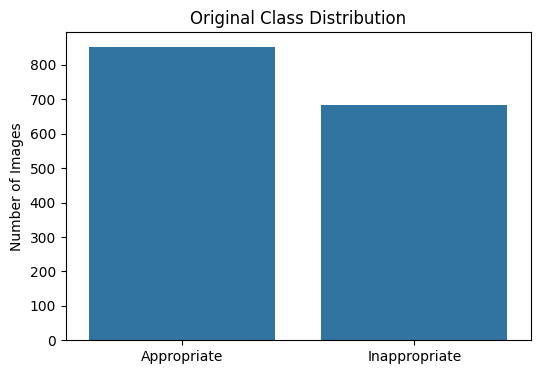

After Augmentation Train set size: 15666
Validation set size: 1119
Test set size: 1119
Balanced class distribution: 852 appropriate, 684 inappropriate


In [3]:

# Dataset path
dataset_path = "./DATASETS/MMU DATASET CROPPED FULL2"

# dataset_path = "./DATASETS/cropped_images_800"
# dataset_path = "./train_45"

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Directory not found: {dataset_path}")

transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize for display
    transforms.ToTensor()
])
val_test_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform_inception = transforms.Compose([
    transforms.Resize((299, 299), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(dataset_path)
dataset_resnet = ImageFolder(dataset_path)
dataset_inception = ImageFolder(dataset_path)
dataset_visual = ImageFolder(dataset_path, transform=transform_visual)  # For showing images

# Extract class names
class_names = dataset_resnet.classes
print(f"Class Names: {class_names}")
# Separate images by class
appropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 0]
inappropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 1]

# Check class sizes
print(f"Appropriate class size: {len(appropriate_indices)}")
print(f"Inappropriate class size: {len(inappropriate_indices)}")
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Original Class Distribution")
plt.ylabel("Number of Images")
plt.show()



# # ALL INDICES
balanced_indices = list(range(len(dataset)))
balanced_indices = shuffle(balanced_indices)

# Define split sizes (e.g., 70% train, 15% val, 15% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure total length matches

# train_idx, val_idx, test_idx = random_split(dataset_inception, [train_size, val_size, test_size])

# Split indices
train_idx = balanced_indices[:train_size]
val_idx = balanced_indices[train_size:train_size + val_size]
test_idx = balanced_indices[train_size + val_size:]

# Create subsets for ResNet
train_resnet = Subset(dataset, train_idx)
val_resnet = Subset(dataset, val_idx)
test_resnet = Subset(dataset, test_idx)


# # Create subsets for Inception (using the same indices)
# train_inception = Subset(dataset, train_idx)
# val_inception = Subset(dataset, val_idx)
# test_inception = Subset(dataset, test_idx)

# print(f"Before Augmentation Train set size: {len(train_resnet)}")
# print(f"Before Augmentation Train set size: {len(train_inception)}")

# # Save train set with augmentations
# save_images(train_resnet, dataset, "train", augment=False)

# # Save validation set without augmentation
# save_images(val_resnet, dataset, "val", augment=False)

# # Save test set without augmentation
# save_images(test_resnet, dataset, "test", augment=False)

# print(f"✅ All datasets saved in {save_dir}")

# train_resnet_aug = AugmentedImageFolder_resnet(train_resnet)
# train_inception_aug = AugmentedImageFolder_inception(train_inception)

# train_resnet_aug = Applytransform_resnet(train_resnet)
# train_inception_aug = Applytransform_inception(train_inception)


# # Apply transformations to val & test sets
# val_resnet_aug = Applytransform_resnet(val_resnet)
# test_resnet_aug = Applytransform_resnet(test_resnet)

# val_inception_aug = Applytransform_inception(val_inception)
# test_inception_aug = Applytransform_inception(test_inception)

# train_resnet_aug = datasets.ImageFolder(root=os.path.join(save_dir, "train"), transform=val_test_transform_resnet)
# val_resnet_aug = datasets.ImageFolder(root=os.path.join(save_dir, "val"), transform=val_test_transform_resnet)
# test_resnet_aug = datasets.ImageFolder(root=os.path.join(save_dir, "test"), transform=val_test_transform_resnet)

# train_inception_aug = datasets.ImageFolder(root=os.path.join(save_dir, "train"), transform=val_test_transform_inception)
# val_inception_aug = datasets.ImageFolder(root=os.path.join(save_dir, "val"), transform=val_test_transform_inception)
# test_inception_aug = datasets.ImageFolder(root=os.path.join(save_dir, "test"), transform=val_test_transform_inception)


# train_loader_resnet = DataLoader(train_resnet_aug, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
# val_loader_resnet = DataLoader(val_resnet_aug, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
# test_loader_resnet = DataLoader(test_resnet_aug, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)

# train_loader_inception = DataLoader(train_inception_aug, batch_size=32, shuffle=True, num_workers=4,pin_memory=True)
# val_loader_inception = DataLoader(val_inception_aug, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)
# test_loader_inception = DataLoader(test_inception_aug, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)


# train_subset = Subset(dataset, train_idx)
# val_subset = Subset(dataset, val_idx)
# test_subset = Subset(dataset, test_idx)

# train_datasets = DualTransformDataset(train_subset)
# val_dataset = DualTransformDataset(val_subset)
# test_dataset = DualTransformDataset(test_subset)

train_dataset = DualTransformDataset_2(root=os.path.join(save_dir, "train"))

val_dataset = DualTransformDataset_2(root=os.path.join(save_dir, "val"))

test_dataset = DualTransformDataset_2(root=os.path.join(save_dir, "test"))
   

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)






print(f"After Augmentation Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# print(f"After Augmentation Train set size: {len(train_inception_aug)}")
# print(f"Validation set size: {len(val_inception_aug)}")
# print(f"Test set size: {len(test_inception_aug)}")


# Check class distribution in the balanced dataset
print(f"Balanced class distribution: {len(appropriate_indices)} appropriate, {len(inappropriate_indices)} inappropriate")



## sample images

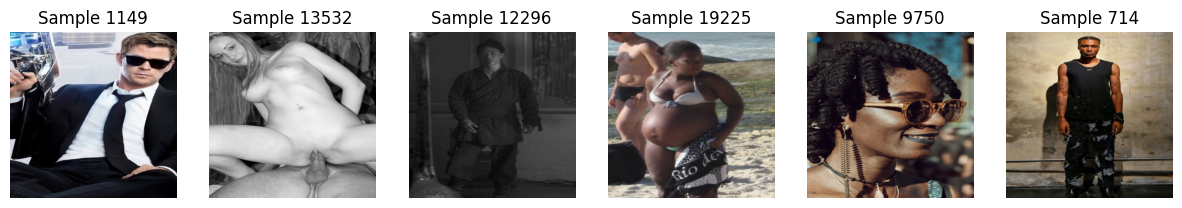

In [3]:
import random

# Function to visualize multiple random augmented images
def visualize_random_augmentations(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    # Pick random indices to ensure variety
    random_indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Get a randomly chosen augmented image

        # Convert tensor to numpy
        image_np = image.permute(1, 2, 0).cpu().numpy()

        # Reverse normalization for better visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean  # Undo normalization
        image_np = np.clip(image_np, 0, 1)  # Clip values to valid range

        axes[i].imshow(image_np)
        axes[i].axis("off")
        axes[i].set_title(f"Sample {idx}")

    plt.show()

# Test function
visualize_random_augmentations(AugmentedImageFolder_inception(dataset))


In [ ]:
# Sample and show images from both classes
def show_images(indices, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(random.sample(indices, num_images)):
        img, label = dataset_visual[idx]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert to (H, W, C)
        axes[i].set_title(class_names[label])
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

show_images(appropriate_indices, "Sample: Appropriate Content")
show_images(inappropriate_indices, "Sample: Inappropriate Content")




In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display original vs. augmented images
def show_all_augmentations(train_dataset, raw_dataset, num_images=5):
    fig, axes = plt.subplots(5, num_images, figsize=(15, 15))  # 5 augmentations per image

    for i in range(num_images):
        index = random.randint(0, len(train_dataset) // 5 - 1)  # Select original images only
        base_idx = index * 5  # Index of the original image in the augmented dataset

        # Get original file path (before transformation)
        img_path, label_original = raw_dataset.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)
        mode_original = img_pil.mode  # Check mode

        # # ✅ Ensure image is in RGB mode
        # if mode_original != "RGB":
        #     img_pil = img_pil.convert("RGB")

        # Load images from train_dataset (already transformed)
        aug_names = ["Original", "Flipped", "Grayscale", "Darkened", "Whitened"]
        for j in range(5):  # 5 versions of each image
            img_aug, label_aug = train_dataset[base_idx + j]

            # Move tensor to CPU before converting to numpy
            img_aug_np = img_aug.cpu().permute(1, 2, 0).numpy()

            # Display the image
            axes[j, i].imshow(img_aug_np, cmap="gray" if j == 2 else None)
            axes[j, i].set_title(f"{aug_names[j]}\n{raw_dataset.classes[label_aug]}")
            axes[j, i].axis("off")

    plt.suptitle("Original vs. Augmented Images from Dataset")
    plt.show()

# Call function using the correct dataset
show_all_augmentations(train_resnet_aug, dataset)


In [ ]:
def denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 1, 3)
    std = torch.tensor(std).view(1, 1, 3)
    img = img * std + mean  # Undo normalization
    return img.clamp(0, 1)  # Keep values in range [0,1] for proper visualization

def show_all_augmentations(train_dataset, raw_dataset, num_images=5):
    fig, axes = plt.subplots(5, num_images, figsize=(15, 20))  # 5 augmentations per image

    aug_names = ["darkened", "flipped", "grayscale", "original", "whitened"]

    for i in range(num_images):
        index = random.randint(0, len(train_dataset) // 5 - 1)  # Select a random original image
        base_idx = index * 5  # Starting index of the 5 augmentations

        # Get original file path (before transformation)
        img_path, label_original = raw_dataset.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)

        # # Ensure image is in RGB mode
        if img_pil.mode != "RGB":
            img_pil = img_pil.convert("RGB")

        # Load images from the transformed dataset
        for j in range(5):  # Display all 5 augmentations
            img_aug, label_aug = train_dataset[base_idx + j]

            # Move tensor to CPU before converting to NumPy
          # With this:
            img_aug = denormalize(img_aug.permute(1, 2, 0))  # Undo normalization
            img_aug_np = img_aug.cpu().numpy()
                        # Apply grayscale colormap if displaying grayscale
            cmap = "gray" if aug_names[j] == "Grayscale" else None

            # Display the image
            axes[j, i].imshow(img_aug_np, cmap=cmap)
            axes[j, i].set_title(f"{aug_names[j]}\n{raw_dataset.classes[label_aug]}")
            axes[j, i].axis("off")

    plt.suptitle("Original vs. Augmented Images from Dataset")
    plt.show()

# Call function using the correct dataset
show_all_augmentations(train_dataset, dataset)


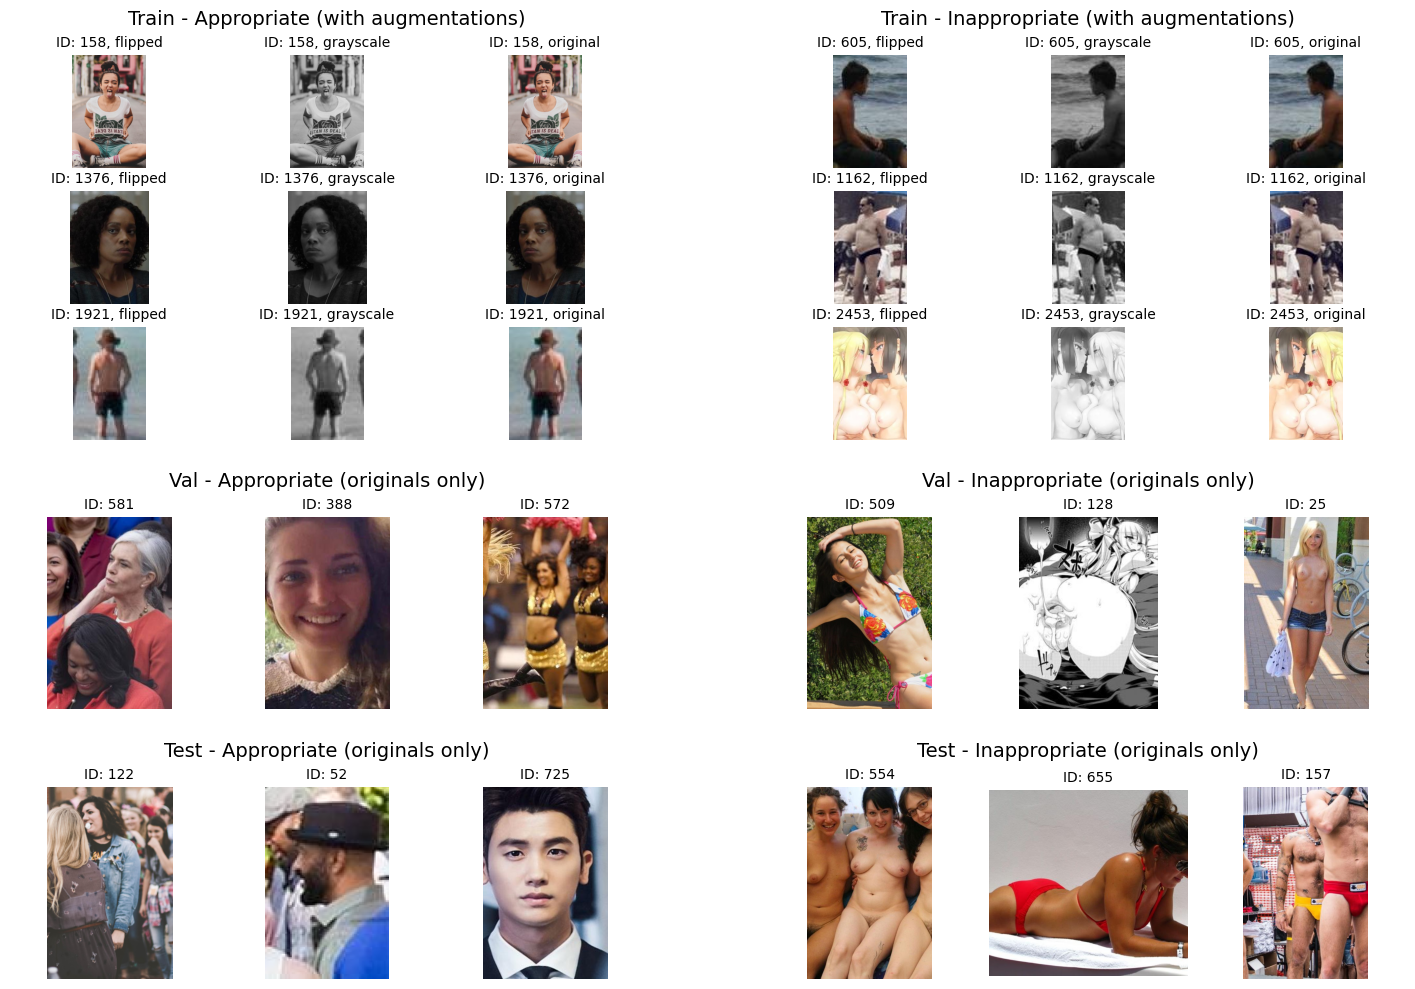

In [22]:

def display_dataset_images(root_dir, num_images=3, figsize=(18, 12)):
    """
    Display images from a dataset with train/val/test splits and appropriate/inappropriate categories.
    Train images have augmentations, while val/test have original images only.
    
    Args:
        root_dir (str): Root directory of the dataset
        num_images (int): Number of images to display per category
        figsize (tuple): Figure size for the plot
    """
    # Define the structure
    splits = ['train', 'val', 'test']
    categories = ['appropriate', 'inappropriate']
    
    # Create a figure with two rows (train augmentations, and val/test originals)
    fig = plt.figure(figsize=figsize)
    
    # Define grid specs - one for train with augmentations, one for val, one for test
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.2)
    
    # Process train images (with augmentations)
    for j, category in enumerate(categories):
        train_dir = os.path.join(root_dir, 'train', category)
        
        if not os.path.exists(train_dir):
            ax = fig.add_subplot(gs[0, j])
            ax.text(0.5, 0.5, f"No {category} images in train", 
                   horizontalalignment='center', verticalalignment='center')
            ax.axis('off')
            continue
        
        # Get all image files
        image_files = [f for f in os.listdir(train_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        if not image_files:
            ax = fig.add_subplot(gs[0, j])
            ax.text(0.5, 0.5, f"No images found in train/{category}", 
                   horizontalalignment='center', verticalalignment='center')
            ax.axis('off')
            continue
        
        # Group images by their base ID (before the augmentation suffix)
        base_images = {}
        for img_file in image_files:
            if '_' in img_file:
                base_id = img_file.split('_')[0]
                aug_type = img_file.split('_')[-1].split('.')[0]
                
                if base_id not in base_images:
                    base_images[base_id] = {}
                
                base_images[base_id][aug_type] = img_file
            else:
                # Handle original images without augmentation suffix
                base_id = img_file.split('.')[0]
                if base_id not in base_images:
                    base_images[base_id] = {}
                base_images[base_id]['original'] = img_file
        
        # Randomly select image groups to display
        selected_base_ids = random.sample(list(base_images.keys()), 
                                          min(num_images, len(base_images)))
        
        # Create a nested subplot for train augmentations
        train_inner_gs = gs[0, j].subgridspec(len(selected_base_ids), 3, wspace=0.1, hspace=0.2)
        
        # Set the title for this section
        ax_title = fig.add_subplot(gs[0, j])
        ax_title.set_title(f"Train - {category.capitalize()} (with augmentations)\n", fontsize=14)
        ax_title.axis('off')
        
        # Display each selected image group with its augmentations
        for i, base_id in enumerate(selected_base_ids):
            augs = base_images[base_id]
            
            # Sort augmentations to ensure consistent order
            aug_types = sorted(augs.keys())
            
            for k, aug_type in enumerate(aug_types):
                img_file = augs[aug_type]
                img_path = os.path.join(train_dir, img_file)
                
                # Create subplot
                ax = fig.add_subplot(train_inner_gs[i, k])
                
                # Display image
                img = Image.open(img_path).convert('RGB')
                ax.imshow(np.array(img))
                ax.set_title(f"ID: {base_id}, {aug_type}", fontsize=10)
                ax.axis('off')
    
    # Process val and test images (originals only)
    for i, split in enumerate(['val', 'test']):
        for j, category in enumerate(categories):
            split_dir = os.path.join(root_dir, split, category)
            
            if not os.path.exists(split_dir):
                ax = fig.add_subplot(gs[i+1, j])
                ax.text(0.5, 0.5, f"No {category} images in {split}", 
                       horizontalalignment='center', verticalalignment='center')
                ax.axis('off')
                continue
            
            # Get all image files
            image_files = [f for f in os.listdir(split_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
            
            if not image_files:
                ax = fig.add_subplot(gs[i+1, j])
                ax.text(0.5, 0.5, f"No images found in {split}/{category}", 
                       horizontalalignment='center', verticalalignment='center')
                ax.axis('off')
                continue
            
            # Randomly select images to display
            selected_files = random.sample(image_files, min(num_images, len(image_files)))
            
            # Create a nested subplot for this category
            inner_gs = gs[i+1, j].subgridspec(1, min(num_images, len(image_files)), wspace=0.1)
            
            # Set title
            ax_title = fig.add_subplot(gs[i+1, j])
            ax_title.set_title(f"{split.capitalize()} - {category.capitalize()} (originals only)\n", fontsize=14)
            ax_title.axis('off')
           
            # Display each selected image
            for k, img_file in enumerate(selected_files):
                img_path = os.path.join(split_dir, img_file)
                
                # Create subplot
                ax = fig.add_subplot(inner_gs[0, k])
                
                # Display image
                img = Image.open(img_path).convert('RGB')
                ax.imshow(np.array(img))
                ax.set_title(f"ID: {img_file.split('.')[0]}", fontsize=10)
                ax.axis('off')
    
    # plt.tight_layout()
    plt.show()


display_dataset_images(save_dir)

## Model Initialization

In [160]:

# # Define the model
# class FusionModel(nn.Module):
#     def __init__(self, num_classes):
#         super(FusionModel, self).__init__()
        
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#         pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
#         self.inception = models.inception_v3(aux_logits=False)
#         state_dict = pretrained_model.state_dict()
#         self.inception.load_state_dict(state_dict, strict=False)
        
#         # Step 1: Freeze All Layers Initially**
#         for param in self.resnet.parameters():
#             param.requires_grad = False
#         for param in self.inception.parameters():
#             param.requires_grad = False
        
#         # for param in self.resnet.fc.parameters():
#         #       param.requires_grad = True
#         # for param in self.inception.fc.parameters():
#         #       param.requires_grad = True    
              
#         self.resnet.fc = nn.Identity()
#         self.inception.fc = nn.Identity()
                   
#         # self.resnet.fc = None
#         # self.inception.fc = None
        
#         self.batch_norm = nn.BatchNorm1d(4096)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(4096, num_classes)
        
#     def forward(self, x_resnet, x_inception):
#         resnet_features = self.resnet(x_resnet)
       
#         inception_features = self.inception(x_inception)


#         if isinstance(inception_features, tuple):  # InceptionV3 returns a tuple
#             inception_features = inception_features[0]  # Take only the main output
#         fused_features = torch.cat((resnet_features, inception_features), dim=1)
#         fused_features = self.batch_norm(fused_features)
#         fused_features = self.relu(fused_features)
#         fused_features = self.dropout(fused_features)
#         output = torch.sigmoid(self.fc(fused_features))
#         output = self.fc(fused_features)  # No sigmoid here

#         return output


# class FusionModel(nn.Module):
#     def __init__(self, num_classes):
#         super(FusionModel, self).__init__()

#         # Load pretrained ResNet50 and freeze all layers
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#         for param in self.resnet.parameters():
#             param.requires_grad = False
#         self.resnet.fc = nn.Identity()  # Remove ResNet FC layer
   
#         pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
#         self.inception_model = models.inception_v3(aux_logits=False)
#         self.inception_model.load_state_dict(pretrained_model.state_dict(), strict=False)


#         # Freeze all Inception layers
#         for param in self.inception_model.parameters():
#             param.requires_grad = False
            
#         self.inception_model.fc = nn.Identity()
#         self.inception_preprocess = nn.Sequential(
#             self.inception_model.Conv2d_1a_3x3,
#             self.inception_model.Conv2d_2a_3x3,
#             self.inception_model.Conv2d_2b_3x3,
#             self.inception_model.maxpool1,
#             self.inception_model.Conv2d_3b_1x1,
#             self.inception_model.Conv2d_4a_3x3,
#             self.inception_model.maxpool2,
#             self.inception_model.Mixed_5b,
#             self.inception_model.Mixed_5c,
#             self.inception_model.Mixed_5d,

#         )

#         # ✅ **Only keep high-level Inception layers**
#         self.inception_top_layers = nn.Sequential(
#             self.inception_model.Mixed_6a,
#             self.inception_model.Mixed_6b,
#             self.inception_model.Mixed_6c,
#             self.inception_model.Mixed_6d,
#             self.inception_model.Mixed_6e,
#             self.inception_model.Mixed_6d,
#             self.inception_model.Mixed_6e,
#             self.inception_model.Mixed_7a,
#             self.inception_model.Mixed_7b,
#             self.inception_model.Mixed_7c,
#             nn.AdaptiveAvgPool2d((1, 1)),  # Global avg pooling
#             # nn.Flatten()  # Flatten to 1D
#         )
        
       
#         # Fusion layer (concatenating 2048+2048 features)
#         self.fc = nn.Sequential(
#             nn.Linear(4096, 256),  # Compress to 512 features
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes),
#             nn.Sigmoid()
#         )

#     def forward(self, x_resnet, x_inception):
#         # Extract ResNet50 features
#         resnet_features = self.resnet(x_resnet)
#         # print(f"ResNet Features Shape: {resnet_features.shape}")  # Debugging Output


#         # ✅ **Process input through necessary Inception layers to get correct shape**
#         x_inception = self.inception_preprocess(x_inception)
#         # print(f"Inception Features Shape: {x_inception.shape}")  # Debugging Output

#         inception_features = self.inception_top_layers(x_inception).squeeze(-1).squeeze(-1)        
#         # print(f"Inception Features Shape: {inception_features.shape}")  # Debugging Output

#         # Concatenate features
        
#         fused_features = torch.cat((resnet_features,inception_features), dim=1)
      
#         output = self.fc(fused_features)

#         return output

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()

        # Load pre-trained ResNet50
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Remove the fully connected layer
        self.resnet.fc = nn.Identity()

    def forward(self, x):
        features = self.resnet(x)  # Extract features (2048-dim vector)
        return features
    
from torchvision.models.inception import Inception_V3_Weights

class InceptionV3Model(nn.Module):
    def __init__(self):
        super(InceptionV3Model, self).__init__()

        # Load pre-trained InceptionV3
        pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        self.inception = models.inception_v3(aux_logits=False)
        state_dict = pretrained_model.state_dict()
        self.inception.load_state_dict(state_dict, strict=False)

        # Remove the fully connected layer
        self.inception.fc = nn.Identity()

    def forward(self, x):
        features = self.inception(x)

        if isinstance(features, tuple):  # InceptionV3 sometimes returns a tuple
            features = features[0]

        return features  # Extracted feature vector (2048-dim)
    
class FusionModel(nn.Module):
    def __init__(self, num_classes=1):
        super(FusionModel, self).__init__()

        # Load feature extractors
        self.resnet_model = ResNet50Model()
        self.inception_model = InceptionV3Model()
        
        # ✅ Freeze all Inception and ResNet layers
        for param in self.inception_model.inception.parameters():
            param.requires_grad = False
        for param in self.resnet_model.resnet.parameters():
            param.requires_grad = False

        # ✅ Use correct reference for InceptionV3 layers
        self.inception_preprocess = nn.Sequential(
            self.inception_model.inception.Conv2d_1a_3x3,
            self.inception_model.inception.Conv2d_2a_3x3,
            self.inception_model.inception.Conv2d_2b_3x3,
            self.inception_model.inception.maxpool1,
            self.inception_model.inception.Conv2d_3b_1x1,
            self.inception_model.inception.Conv2d_4a_3x3,
            self.inception_model.inception.maxpool2,
            self.inception_model.inception.Mixed_5b,
            self.inception_model.inception.Mixed_5c,
            self.inception_model.inception.Mixed_5d,
            self.inception_model.inception.Mixed_6a,
            self.inception_model.inception.Mixed_6b,
            self.inception_model.inception.Mixed_6c,
            self.inception_model.inception.Mixed_6d,
            self.inception_model.inception.Mixed_6e,
          
        )

        # ✅ Extract only Mixed_6d to Mixed_7c
        self.inception_top_layers = nn.Sequential(
            self.inception_model.inception.Mixed_7a,
            self.inception_model.inception.Mixed_7b,
            self.inception_model.inception.Mixed_7c,
            nn.AdaptiveAvgPool2d((1, 1)),  # Global avg pooling
            # nn.Flatten()  # Flatten to 1D
        )

        # Fusion layer (concatenating 2048 + 2048 features)
        self.fc = nn.Sequential(
            nn.Linear(4096, 32),  # Reduce to 128 features
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes),
            nn.Sigmoid()
        )

        # self.fc = nn.Sequential(
        #     nn.Linear(4096, 64),  
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(),
        #     nn.Dropout(0.5),  # First dropout
        #     nn.Linear(64, 64),  # Optional additional layer for better learning capacity
        #     nn.ReLU(),
        #     nn.Dropout(0.5),  # Second dropout
        #     nn.Linear(64, num_classes),
        #     nn.Sigmoid()
        # )



    def forward(self, x_resnet, x_inception):
        # Extract ResNet features
        resnet_features = self.resnet_model(x_resnet)


        inception_features = self.inception_preprocess(x_inception)

        inception_features = self.inception_top_layers(inception_features).squeeze(-1).squeeze(-1)        
   
        fused_features = torch.cat((resnet_features, inception_features), dim=1)
       
        output = self.fc(fused_features)

        return output

    
# class FusionModel(nn.Module):
#     def __init__(self, num_classes=1):
#         super(FusionModel, self).__init__()

#         # Load feature extractors
#         self.resnet_model = ResNet50Model()
#         self.inception_model = InceptionV3Model()
#         for param in self.inception_model.inception.parameters():
#             param.requires_grad = False
#         for param in self.resnet_model.resnet.parameters():
#             param.requires_grad = False

#         # Fusion layer (concatenating 2048+2048 features)
#         self.fc = nn.Sequential(
#             nn.Linear(4096, 128),  # Compress to 512 features
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes),
#             nn.Sigmoid()
#         )

#     def forward(self, x_resnet, x_inception):
#         # Extract features
#         resnet_features = self.resnet_model(x_resnet)
#         inception_features = self.inception_model(x_inception)

#         # Concatenate features
#         fused_features = torch.cat((resnet_features, inception_features), dim=1)

#         # Pass through FC layer
#         output = self.fc(fused_features)

#         return output


    
model = FusionModel(num_classes=1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)




e:\THESIS PROJECT FOLDER\.venv\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [28]:
import torch

# Example Input (Batch Size = 2, Channels = 3, Image Size = 224x224)
x_resnet = torch.randn(2, 3, 224, 224)  # Input for ResNet50
x_inception = torch.randn(2, 3, 299, 299)  # Input for InceptionV3

model = FusionModel(num_classes=1)  # Assuming binary classification
output = model(x_resnet, x_inception)


### model summary

In [29]:


torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(model)
summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

FusionModel(
  (resnet_model): ResNet50Model(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu):

## Plots

In [9]:
def plot_from_history(history):
    # Extract data from history
    epochs = history["epoch"]
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    train_accuracies = history["train_accuracy"]
    val_accuracies = history["val_accuracy"]

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.savefig('training_history.png')  # PNG image
    plt.show()
  
def plot_roc_curve(metrics):
    auc_score = metrics['auc_roc'][0]
  
    roc_fpr = list(map(float, metrics['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics['roc_curve_tpr'][0].split(', ')))
    # Plot ROC Curve
    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()
def plot_metrics(metrics_df):
    # Extract individual metrics
    auc_score = metrics_df['auc_roc'][0]
    fpr = metrics_df['fpr'][0]
    fnr = metrics_df['fnr'][0]

    # Extract confusion matrix (flattened form)
    conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
    tn, fp, fn, tp = conf_matrix

    # Extract ROC curve data (flattened form)
    roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
    # Confusion Matrix heatmap
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot FPR and FNR
    plt.figure(figsize=(8, 6))
    plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
    plt.ylabel('Rate')
    plt.title('Final FPR and FNR')
    plt.ylim(0, 1)
    plt.show()

    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


## TRAIN LOOP

In [147]:
# Training loop
def train_model(model, train_loader_resnet, train_loader_inception, val_loader_resnet, val_loader_inception, 
                criterion, optimizer, epochs=5,scheduler=None):
                  
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
    "epoch": [],
    "class_names": [],
    "confusion_matrix": [],
    "accuracy": [],
    "fpr": [],
    "fnr": [],
    "auc_roc": [],
    "roc_curve_fpr": [],
    "roc_curve_tpr": []
}

    initial_weights = model.inception_model.inception.Mixed_6d.branch7x7dbl_5.conv.weight.clone()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm on the zip object directly
        progress_bar = tqdm(zip(train_loader_resnet, train_loader_inception), 
                             total=len(train_loader_resnet), 
                             desc=f"Epoch {epoch+1}/{epochs}")
        assert len(train_loader_resnet) == len(train_loader_inception), "Data loaders have different lengths!"

        for (resnet_batch, inception_batch) in progress_bar:
            x_resnet, y = resnet_batch
            x_inception, y_ = inception_batch
            
            if torch.equal(y, y_):
                print("✅ Labels match!")
            else:
                print("🚨 Labels mismatch!")
                print("ResNet Labels:", y[:50])
                print("Inception Labels:", y_[:50])
                    
            # Move data to the appropriate device
            x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_resnet, x_inception).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            # Check for parameters that are not getting gradients
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is None:
                    print(f"🚨 {name} is NOT getting gradients!")

            optimizer.step()
            

            running_loss += loss.item()

            preds = (outputs > 0.5).float()  # ✅ Logits threshold at 0 (not 0.5 since no sigmoid in forward)          
            correct += (preds == y).sum().item()
            total += y.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
            

        epoch_loss = running_loss / len(train_loader_resnet)
        epoch_acc = 100 * correct / total
       
        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for (resnet_batch, inception_batch) in zip(val_loader_resnet, val_loader_inception):
                x_resnet, y = resnet_batch
                x_inception, _ = inception_batch
                x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

                outputs = model(x_resnet, x_inception).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()  # ✅ Logits threshold at 0 (not 0.5 since no sigmoid in forward)                
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
                
                
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())


        val_loss /= len(val_loader_resnet)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        
        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")
        
        # Store metrics
       
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
     

        model.train()  # Return model to training mode
        if scheduler:
                # scheduler.step(val_loss)
                print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
                scheduler.step()
                print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

            # scheduler.step()  

    print("Training complete")
    print("Weights changed:", not torch.equal(initial_weights, model.inception_model.inception.Mixed_6d.branch7x7dbl_5.conv.weight))

    # Compute Additional Metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    print("\nAdditional Metrics:") 
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print
    # Save Additional Metrics
  # Update metrics dictionary for the current epoch (replace `epoch_number` with actual epoch)
    metrics["class_names"].append(class_names)
    metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    metrics["fpr"].append(fpr)
    metrics["fnr"].append(fnr)
    metrics["auc_roc"].append(auc_score)
    metrics["roc_curve_fpr"].append(fpr_vals)
    metrics["roc_curve_tpr"].append(tpr_vals)
   
    return history, metrics  # Return history dictionary for immediate plotting if needed


from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Training loop
def train_model_proposed(model, train_loader, val_loader, criterion, optimizer, epochs=5, scheduler=None, device="cuda"):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        model.train()
        for batch in progress_bar:
            x_resnet, x_inception, labels = batch
            x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()
                              
            optimizer.zero_grad()
            outputs = model(x_resnet, x_inception).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                x_resnet, x_inception, labels = batch
                x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()


                outputs = model(x_resnet, x_inception).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

        # Store metrics
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Compute Additional Metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_prob)
        fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
        tn, fp, fn, tp = conf_matrix.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        print("\nAdditional Metrics:") 
        print(f"False Positive Rate (FPR): {fpr:.4f}")
        print(f"False Negative Rate (FNR): {fnr:.4f}")
        print(f"AUC-ROC Score: {auc_score:.4f}")
        print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

        # Save Additional Metrics
        metrics["class_names"].append(["Appropriate", "Inappropriate"])
        metrics["confusion_matrix"].append(conf_matrix.ravel())
        metrics["fpr"].append(fpr)
        metrics["fnr"].append(fnr)
        metrics["auc_roc"].append(auc_score)
        metrics["roc_curve_fpr"].append(fpr_vals)
        metrics["roc_curve_tpr"].append(tpr_vals)

        model.train()  # Return model to training mode
        if scheduler:
            print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
            scheduler.step()
            print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

    print("Training complete")
    return history, metrics





### Finetune def

In [133]:

# Training loop
def finetune_model_proposed(model, train_loader, val_loader, criterion, optimizer=None, epochs=5, scheduler=None, device="cuda",weight_decay=0.001):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
                 # Gradually unfreeze layers based on epoch
        if epoch == 4:
            print("Unfreezing Mixed_7c and layer4[2]")
            # Unfreeze specific layers
            for param in model.inception_model.inception.Mixed_7c.parameters():
                param.requires_grad = True
            for param in model.resnet_model.resnet.layer4[2].parameters():
                param.requires_grad = True
                
            # Update optimizer with newly unfrozen parameters
            optimizer = torch.optim.Adamax([
                {"params": model.fc.parameters(), "lr": 0.001, "weight_decay": weight_decay},
                {"params": model.inception_model.inception.Mixed_7c.parameters(), "lr": 0.0001, "weight_decay": weight_decay},
                {"params": model.resnet_model.resnet.layer4[2].parameters(), "lr": 0.0001, "weight_decay": weight_decay}
            ])

        elif epoch == 6:
            print("Unfreezing Mixed_7b and layer4[1]")
            # Unfreeze more layers
            for param in model.inception_model.inception.Mixed_7b.parameters():
                param.requires_grad = True
            for param in model.resnet_model.resnet.layer4[1].parameters():
                param.requires_grad = True
                
            # Update optimizer with all trainable parameters
            optimizer = torch.optim.Adamax([
                {"params": model.fc.parameters(), "lr": 0.001, "weight_decay": weight_decay},
                {"params": model.inception_model.inception.Mixed_7c.parameters(), "lr": 0.0001, "weight_decay": weight_decay},
                {"params": model.inception_model.inception.Mixed_7b.parameters(), "lr": 0.00001, "weight_decay": weight_decay},
                {"params": model.resnet_model.resnet.layer4[2].parameters(), "lr": 0.0001, "weight_decay": weight_decay},
                {"params": model.resnet_model.resnet.layer4[1].parameters(), "lr": 0.00001, "weight_decay": weight_decay}
            ])

        elif epoch == 8:
            print("Unfreezing Mixed_7a and layer4[0]")
            # Unfreeze final set of layers
            for param in model.inception_model.inception.Mixed_7a.parameters():
                param.requires_grad = True
            for param in model.resnet_model.resnet.layer4[0].parameters():
                param.requires_grad = True
                
            # Update optimizer with all trainable parameters
            optimizer = torch.optim.Adamax([
                {"params": model.fc.parameters(), "lr": 0.001, "weight_decay": weight_decay},
                {"params": model.inception_model.inception.Mixed_7c.parameters(), "lr": 0.0001, "weight_decay": weight_decay},
                {"params": model.inception_model.inception.Mixed_7b.parameters(), "lr": 0.00001, "weight_decay": weight_decay},
                {"params": model.inception_model.inception.Mixed_7a.parameters(), "lr": 0.000005, "weight_decay": weight_decay},
                {"params": model.resnet_model.resnet.layer4[2].parameters(), "lr": 0.0001, "weight_decay": weight_decay},
                {"params": model.resnet_model.resnet.layer4[1].parameters(), "lr": 0.00001, "weight_decay": weight_decay},
                {"params": model.resnet_model.resnet.layer4[0].parameters(), "lr": 0.000005, "weight_decay": weight_decay}
            ])
            
        # Print number of trainable parameters to verify unfreezing
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Epoch {epoch+1}: Number of trainable parameters: {trainable_params}")

        # Progress bar for training
        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        model.train()
        for batch in progress_bar:
            x_resnet, x_inception, labels = batch
            x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()
                              
            optimizer.zero_grad()
            outputs = model(x_resnet, x_inception).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                x_resnet, x_inception, labels = batch
                x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()


                outputs = model(x_resnet, x_inception).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

        # Store metrics
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Compute Additional Metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_prob)
        fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
        tn, fp, fn, tp = conf_matrix.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        print("\nAdditional Metrics:") 
        print(f"False Positive Rate (FPR): {fpr:.4f}")
        print(f"False Negative Rate (FNR): {fnr:.4f}")
        print(f"AUC-ROC Score: {auc_score:.4f}")
        print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

        # Save Additional Metrics
        metrics["class_names"].append(["Appropriate", "Inappropriate"])
        metrics["confusion_matrix"].append(conf_matrix.ravel())
        metrics["fpr"].append(fpr)
        metrics["fnr"].append(fnr)
        metrics["auc_roc"].append(auc_score)
        metrics["roc_curve_fpr"].append(fpr_vals)
        metrics["roc_curve_tpr"].append(tpr_vals)

        model.train()  # Return model to training mode
        if scheduler:
            print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
            scheduler.step()
            print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

    print("Training complete")
    return history, metrics

### finetune2

In [103]:
def finetune_model_proposed2(model, train_loader, val_loader, criterion, optimizer=None, epochs=5, scheduler=None, 
                             device="cuda", weight_decay=0.001, lr_decay_factor=0.6):
    # 0.8 decay factor on finetune2
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    # Track which parameter groups have been added to optimizer
    optimized_param_ids = set()
    
    # Track layer unfreeze history for LR decay management
    layer_unfreeze_history = {
        "fc": {"epoch_unfrozen": 0, "param_group_idx": 0, "no_decay": True},  # Mark FC layer to skip decay
        "inception_7c": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
        "inception_7b": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
        "inception_7a": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
        "resnet_layer4_2": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
        "resnet_layer4_1": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
        "resnet_layer4_0": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
    }
    
    model.to(device)

    # Initialize optimizer with only FC params
    if optimizer is None:
        optimizer = torch.optim.Adamax(model.fc.parameters(), lr=0.0001, weight_decay=weight_decay)
    
    # Track which parameters are in the optimizer
    for group in optimizer.param_groups:
        for param in group["params"]:
            optimized_param_ids.add(id(param))

    for epoch in range(epochs):
        # 1. Apply learning rate decay to previously unfrozen layers, but skip FC layer
        for layer_name, info in layer_unfreeze_history.items():
            if (info["epoch_unfrozen"] is not None and 
                epoch > info["epoch_unfrozen"] and 
                not info["no_decay"]):
                
                # Find the next unfreezing epoch after this layer was unfrozen
                next_unfreeze_epoch = float('inf')  # Default to infinity if no more unfreezing
                for other_info in layer_unfreeze_history.values():
                    if (other_info["epoch_unfrozen"] is not None and 
                        other_info["epoch_unfrozen"] > info["epoch_unfrozen"] and 
                        other_info["epoch_unfrozen"] < next_unfreeze_epoch):
                        next_unfreeze_epoch = other_info["epoch_unfrozen"]
                
                # Only apply decay if we haven't reached the next unfreezing point
                if epoch < next_unfreeze_epoch:
                    epochs_since_unfreeze = epoch - info["epoch_unfrozen"]
                    # Apply decay based on how many epochs have passed since unfreezing
                    new_lr = optimizer.param_groups[info["param_group_idx"]]["lr"] * lr_decay_factor
                    new_lr = max(new_lr, 0.000001) 
                    print(f"Decaying LR for {layer_name} from {optimizer.param_groups[info['param_group_idx']]['lr']:.8f} to {new_lr:.8f}")
                    optimizer.param_groups[info["param_group_idx"]]["lr"] = new_lr
                else:
                    print(f"Stopped decay for {layer_name} as new layers were unfrozen at epoch {next_unfreeze_epoch}")

        # 2. Unfreeze layers based on the current epoch
        if epoch == 1:
            print("Unfreezing Mixed_7c and layer4[2]")
            
            # Unfreeze Inception Mixed_7c
            for param in model.inception_model.inception.Mixed_7c.parameters():
                param.requires_grad = True
                if id(param) not in optimized_param_ids:
                    optimized_param_ids.add(id(param))
            
            # Unfreeze ResNet layer4[2]
            # for param in model.resnet_model.resnet.layer4[2].parameters():
            #     param.requires_grad = True
            for param in list(model.resnet_model.resnet.parameters())[-3:]:
                param.requires_grad = True
                if id(param) not in optimized_param_ids:
                    optimized_param_ids.add(id(param))
            
            # Add inception Mixed_7c parameters to optimizer
            if any(p.requires_grad for p in model.inception_model.inception.Mixed_7c.parameters()):
                optimizer.add_param_group({
                    "params": [p for p in model.inception_model.inception.Mixed_7c.parameters() if p.requires_grad],
                    "lr": 0.0001,
                    "weight_decay": weight_decay
                })
                # Record the param group index for later LR updates
                layer_unfreeze_history["inception_7c"]["epoch_unfrozen"] = epoch
                layer_unfreeze_history["inception_7c"]["param_group_idx"] = len(optimizer.param_groups) - 1
                
            # Add ResNet layer4[2] parameters to optimizer
            # if any(p.requires_grad for p in model.resnet_model.resnet.layer4[2].parameters()):
            #     optimizer.add_param_group({
            #         "params": [p for p in model.resnet_model.resnet.layer4[2].parameters() if p.requires_grad],
            #         "lr": 0.0001,
            #         "weight_decay": weight_decay
            #     })
            last_three_params = list(model.resnet_model.resnet.parameters())[-3:]
            if any(p.requires_grad for p in last_three_params):
                optimizer.add_param_group({
                    "params": [p for p in last_three_params if p.requires_grad],
                    "lr": 0.0001,
                    "weight_decay": weight_decay
                })
                # Record the param group index for later LR updates
                layer_unfreeze_history["resnet_layer4_2"]["epoch_unfrozen"] = epoch
                layer_unfreeze_history["resnet_layer4_2"]["param_group_idx"] = len(optimizer.param_groups) - 1

            # elif epoch == 13:
            print("Unfreezing Mixed_7b and layer4[1]")
            # Unfreeze Inception Mixed_7b
            for param in model.inception_model.inception.Mixed_7b.parameters():
                param.requires_grad = True
                if id(param) not in optimized_param_ids:
                    optimized_param_ids.add(id(param))
            
            # Unfreeze ResNet layer4[1]
            # for param in model.resnet_model.resnet.layer4[1].parameters():
            #     param.requires_grad = True
            # for param in list(model.resnet_model.resnet.parameters())[-6:-3]:
            #     param.requires_grad = True
            #     if id(param) not in optimized_param_ids:
            #         optimized_param_ids.add(id(param))
            resnet_params_slice = list(model.resnet_model.resnet.parameters())[-6:-3]
            for param in resnet_params_slice:
                param.requires_grad = True
                if id(param) not in optimized_param_ids:
                    optimized_param_ids.add(id(param))
            
                    
            # Add Inception Mixed_7b parameters to optimizer
            if any(p.requires_grad for p in model.inception_model.inception.Mixed_7b.parameters()):
                optimizer.add_param_group({
                    "params": [p for p in model.inception_model.inception.Mixed_7b.parameters() if p.requires_grad],
                    "lr": 0.00005,
                    "weight_decay": weight_decay
                })
                # Record the param group index for later LR updates
                layer_unfreeze_history["inception_7b"]["epoch_unfrozen"] = epoch
                layer_unfreeze_history["inception_7b"]["param_group_idx"] = len(optimizer.param_groups) - 1
                
            # Add ResNet layer4[1] parameters to optimizer
            # if any(p.requires_grad for p in model.resnet_model.resnet.layer4[1].parameters()):
            #     optimizer.add_param_group({
            #         "params": [p for p in model.resnet_model.resnet.layer4[1].parameters() if p.requires_grad],
            #         "lr": 0.00005,
            #         "weight_decay": weight_decay
            #     }).
            if any(p.requires_grad for p in resnet_params_slice):
                optimizer.add_param_group({
                    "params": [p for p in resnet_params_slice if p.requires_grad],
                    "lr": 0.00005,
                    "weight_decay": weight_decay
                })
                # Record the param group index for later LR updates
                layer_unfreeze_history["resnet_layer4_1"]["epoch_unfrozen"] = epoch
                layer_unfreeze_history["resnet_layer4_1"]["param_group_idx"] = len(optimizer.param_groups) - 1

        elif epoch == 3:
            print("Unfreezing Mixed_7a and layer4[0]")
            # Unfreeze Inception Mixed_7a
            for param in model.inception_model.inception.Mixed_7a.parameters():
                param.requires_grad = True
                if id(param) not in optimized_param_ids:
                    optimized_param_ids.add(id(param))
            
            # Unfreeze ResNet layer4[0]
            # for param in model.resnet_model.resnet.layer4[0].parameters():
            #     param.requires_grad = True
            #     if id(param) not in optimized_param_ids:
            #         optimized_param_ids.add(id(param))
            resnet_params_slice2 = list(model.resnet_model.resnet.parameters())[-9:-6]
            for param in resnet_params_slice2:
                    param.requires_grad = True
                    if id(param) not in optimized_param_ids:
                        optimized_param_ids.add(id(param))
            
            # Add Inception Mixed_7a parameters to optimizer
            if any(p.requires_grad for p in model.inception_model.inception.Mixed_7a.parameters()):
                optimizer.add_param_group({
                    "params": [p for p in model.inception_model.inception.Mixed_7a.parameters() if p.requires_grad],
                    "lr": 0.00001,
                    "weight_decay": weight_decay
                })
                # Record the param group index for later LR updates
                layer_unfreeze_history["inception_7a"]["epoch_unfrozen"] = epoch
                layer_unfreeze_history["inception_7a"]["param_group_idx"] = len(optimizer.param_groups) - 1
                
            # Add ResNet layer4[0] parameters to optimizer
            # if any(p.requires_grad for p in model.resnet_model.resnet.layer4[0].parameters()):
            #     optimizer.add_param_group({
            #         "params": [p for p in model.resnet_model.resnet.layer4[0].parameters() if p.requires_grad],
            #         "lr": 0.00001,
            #         "weight_decay": weight_decay
            #     })
            if any(p.requires_grad for p in resnet_params_slice2):
                optimizer.add_param_group({
                    "params": [p for p in resnet_params_slice2 if p.requires_grad],
                    "lr": 0.00001,
                    "weight_decay": weight_decay
                })
                # Record the param group index for later LR updates
                layer_unfreeze_history["resnet_layer4_0"]["epoch_unfrozen"] = epoch
                layer_unfreeze_history["resnet_layer4_0"]["param_group_idx"] = len(optimizer.param_groups) - 1
            
        # Print current learning rates for all param groups
        print("Current Learning Rates:")
        for i, param_group in enumerate(optimizer.param_groups):
            layer_name = next((name for name, info in layer_unfreeze_history.items() 
                              if info["param_group_idx"] == i), f"unknown-{i}")
            decay_status = "fixed" if any(info["no_decay"] for name, info in layer_unfreeze_history.items() 
                                         if info["param_group_idx"] == i) else "decaying"
            print(f"  Param Group {i} ({layer_name}, {decay_status}): lr = {param_group['lr']:.8f}")
            
        # Print number of trainable parameters and optimizer state
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Epoch {epoch+1}: Number of trainable parameters: {trainable_params}")
        print(f"Optimizer param groups: {len(optimizer.param_groups)}")

        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        model.train()
        for batch in progress_bar:
            x_resnet, x_inception, labels = batch
            x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()
                              
            optimizer.zero_grad()
            outputs = model(x_resnet, x_inception).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                x_resnet, x_inception, labels = batch
                x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()

                outputs = model(x_resnet, x_inception).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

        # Store metrics
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Compute Additional Metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_prob)
        fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
        tn, fp, fn, tp = conf_matrix.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        print("\nAdditional Metrics:") 
        print(f"False Positive Rate (FPR): {fpr:.4f}")
        print(f"False Negative Rate (FNR): {fnr:.4f}")
        print(f"AUC-ROC Score: {auc_score:.4f}")
        print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

        # Save Additional Metrics
        metrics["epoch"].append(epoch + 1)
        metrics["class_names"].append(["Appropriate", "Inappropriate"])
        metrics["confusion_matrix"].append(conf_matrix.ravel())
        metrics["fpr"].append(fpr)
        metrics["fnr"].append(fnr)
        metrics["auc_roc"].append(auc_score)
        metrics["roc_curve_fpr"].append(fpr_vals)
        metrics["roc_curve_tpr"].append(tpr_vals)

        # Use learning rate scheduler if provided
        if scheduler:
            print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
            scheduler.step()
            print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

    print("Training complete")
    print(optimizer)
    return history, metrics

# def finetune_model_proposed2(model, train_loader, val_loader, criterion, optimizer=None, epochs=5, scheduler=None, 
    #                          device="cuda", weight_decay=0.01):
    # history = {
    #     "epoch": [],
    #     "train_loss": [],
    #     "train_accuracy": [],
    #     "val_loss": [],
    #     "val_accuracy": []
    # }
    # metrics = {
    #     "epoch": [],
    #     "class_names": [],
    #     "confusion_matrix": [],
    #     "accuracy": [],
    #     "fpr": [],
    #     "fnr": [],
    #     "auc_roc": [],
    #     "roc_curve_fpr": [],
    #     "roc_curve_tpr": []
    # }

    # # Track which parameter groups have been added to optimizer
    # optimized_param_ids = set()
    
    # model.to(device)


    # # Initialize optimizer with only FC params
    # if optimizer is None:
    #     optimizer = torch.optim.Adamax(model.fc.parameters(), lr=0.0001, weight_decay=weight_decay)
    
    # # Track which parameters are in the optimizer
    # for group in optimizer.param_groups:
    #     for param in group["params"]:
    #         optimized_param_ids.add(id(param))

    # for epoch in range(epochs):
    #     # Gradually unfreeze layers based on epoch
    #     if epoch == 2:
    #         print("Unfreezing Mixed_7c and layer4[2]")
    #         # Unfreeze specific layers
    #         for param in model.inception_model.inception.Mixed_7c.parameters():
    #             param.requires_grad = True
    #             # Add to optimizer if not already added
    #             if id(param) not in optimized_param_ids:
    #                 optimized_param_ids.add(id(param))
            
    #         for param in model.resnet_model.resnet.layer4[2].parameters():
    #             param.requires_grad = True
    #             # Add to optimizer if not already added
    #             if id(param) not in optimized_param_ids:
    #                 optimized_param_ids.add(id(param))
            
    #         # Add new parameter groups to optimizer
    #         if any(p.requires_grad for p in model.inception_model.inception.Mixed_7c.parameters()):
    #             optimizer.add_param_group({
    #                 "params": [p for p in model.inception_model.inception.Mixed_7c.parameters() if p.requires_grad],
    #                 "lr": 0.0001,
    #                 "weight_decay": weight_decay
    #             })
                
    #         if any(p.requires_grad for p in model.resnet_model.resnet.layer4[2].parameters()):
    #             optimizer.add_param_group({
    #                 "params": [p for p in model.resnet_model.resnet.layer4[2].parameters() if p.requires_grad],
    #                 "lr": 0.0001,
    #                 "weight_decay": weight_decay
    #             })

    #     elif epoch == 3:
    #         print("Unfreezing Mixed_7b and layer4[1]")
    #         # Unfreeze more layers
    #         for param in model.inception_model.inception.Mixed_7b.parameters():
    #             param.requires_grad = True
    #             if id(param) not in optimized_param_ids:
    #                 optimized_param_ids.add(id(param))
            
    #         for param in model.resnet_model.resnet.layer4[1].parameters():
    #             param.requires_grad = True
    #             if id(param) not in optimized_param_ids:
    #                 optimized_param_ids.add(id(param))
            
    #         # Add new parameter groups to optimizer
    #         if any(p.requires_grad for p in model.inception_model.inception.Mixed_7b.parameters()):
    #             optimizer.add_param_group({
    #                 "params": [p for p in model.inception_model.inception.Mixed_7b.parameters() if p.requires_grad],
    #                 "lr": 0.00005,
    #                 "weight_decay": weight_decay
    #             })
                
    #         if any(p.requires_grad for p in model.resnet_model.resnet.layer4[1].parameters()):
    #             optimizer.add_param_group({
    #                 "params": [p for p in model.resnet_model.resnet.layer4[1].parameters() if p.requires_grad],
    #                 "lr": 0.00005,
    #                 "weight_decay": weight_decay
    #             })

    #     elif epoch == 4:
    #         print("Unfreezing Mixed_7a and layer4[0]")
    #         # Unfreeze final set of layers
    #         for param in model.inception_model.inception.Mixed_7a.parameters():
    #             param.requires_grad = True
    #             if id(param) not in optimized_param_ids:
    #                 optimized_param_ids.add(id(param))
            
    #         for param in model.resnet_model.resnet.layer4[0].parameters():
    #             param.requires_grad = True
    #             if id(param) not in optimized_param_ids:
    #                 optimized_param_ids.add(id(param))
            
    #         # Add new parameter groups to optimizer
    #         if any(p.requires_grad for p in model.inception_model.inception.Mixed_7a.parameters()):
    #             optimizer.add_param_group({
    #                 "params": [p for p in model.inception_model.inception.Mixed_7a.parameters() if p.requires_grad],
    #                 "lr": 0.00001,
    #                 "weight_decay": weight_decay
    #             })
                
    #         if any(p.requires_grad for p in model.resnet_model.resnet.layer4[0].parameters()):
    #             optimizer.add_param_group({
    #                 "params": [p for p in model.resnet_model.resnet.layer4[0].parameters() if p.requires_grad],
    #                 "lr": 0.00001,
    #                 "weight_decay": weight_decay
    #             })
            
    #     # Print number of trainable parameters and optimizer state
    #     trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #     print(f"Epoch {epoch+1}: Number of trainable parameters: {trainable_params}")
    #     print(f"Optimizer param groups: {len(optimizer.param_groups)}")

    #     running_loss = 0.0
    #     correct = 0
    #     total = 0

    #     # Progress bar for training
    #     progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

    #     model.train()
    #     for batch in progress_bar:
    #         x_resnet, x_inception, labels = batch
    #         x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()
                              
    #         optimizer.zero_grad()
    #         outputs = model(x_resnet, x_inception).squeeze()
    #         loss = criterion(outputs, labels)
    #         loss.backward()
    #         optimizer.step()

    #         running_loss += loss.item()
    #         preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
    #         correct += (preds == labels).sum().item()
    #         total += labels.size(0)

    #         progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    #     epoch_loss = running_loss / len(train_loader)
    #     epoch_acc = 100 * correct / total

    #     # Validation Step
    #     model.eval()
    #     val_loss, val_correct, val_total = 0.0, 0, 0
    #     y_true, y_pred, y_prob = [], [], []

    #     with torch.no_grad():
    #         for batch in val_loader:
    #             x_resnet, x_inception, labels = batch
    #             x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()

    #             outputs = model(x_resnet, x_inception).squeeze()
    #             loss = criterion(outputs, labels)
    #             val_loss += loss.item()

    #             preds = (outputs > 0.5).float()
    #             val_correct += (preds == labels).sum().item()
    #             val_total += labels.size(0)

    #             y_true.extend(labels.cpu().numpy())
    #             y_pred.extend(preds.cpu().numpy())
    #             y_prob.extend(outputs.cpu().numpy())

    #     val_loss /= len(val_loader)
    #     val_acc = 100 * val_correct / val_total if val_total > 0 else 0

    #     print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
    #     print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

    #     # Store metrics
    #     history["epoch"].append(epoch + 1)
    #     history["train_loss"].append(epoch_loss)
    #     history["train_accuracy"].append(epoch_acc)
    #     history["val_loss"].append(val_loss)
    #     history["val_accuracy"].append(val_acc)

    #     # Compute Additional Metrics
    #     conf_matrix = confusion_matrix(y_true, y_pred)
    #     auc_score = roc_auc_score(y_true, y_prob)
    #     fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    #     tn, fp, fn, tp = conf_matrix.ravel()
    #     fpr = fp / (fp + tn)
    #     fnr = fn / (fn + tp)

    #     print("\nAdditional Metrics:") 
    #     print(f"False Positive Rate (FPR): {fpr:.4f}")
    #     print(f"False Negative Rate (FNR): {fnr:.4f}")
    #     print(f"AUC-ROC Score: {auc_score:.4f}")
    #     print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

    #     # Save Additional Metrics
    #     metrics["epoch"].append(epoch + 1)
    #     metrics["class_names"].append(["Appropriate", "Inappropriate"])
    #     metrics["confusion_matrix"].append(conf_matrix.ravel())
    #     metrics["fpr"].append(fpr)
    #     metrics["fnr"].append(fnr)
    #     metrics["auc_roc"].append(auc_score)
    #     metrics["roc_curve_fpr"].append(fpr_vals)
    #     metrics["roc_curve_tpr"].append(tpr_vals)

    #     # Use learning rate scheduler if provided
    #     if scheduler:
    #         print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
    #         scheduler.step()
    #         print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

    # print("Training complete")
    # print(optimizer)
    # return history, metrics
    

### Fine Tune layers

In [140]:

# for param in list(model.inception.parameters())[-132:]:
#     param.requires_grad = True
# for param in list(model.resnet.parameters())[-9:]:
#     param.requires_grad = True
    
# for param in model.resnet.layer3[4].parameters():  # Unfreeze last block in layer3
#     param.requires_grad = True

# for param in model.resnet.layer3[5].parameters():  # Unfreeze second last block in layer3
#     param.requires_grad = True
# for param in model.resnet.layer4[2].parameters():  # Unfreeze last block in layer3
#     param.requires_grad = True
    
# for param in model.resnet.layer4.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
# for param in model.resnet.layer3.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
# Unfreezing the last few Inception blocks
# for param in model.inception_top_layers[0].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True
# for param in model.inception_top_layers[1].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True
# for param in model.inception_top_layers[2].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True

# for param in model.inception_top_layers[3].parameters():  # Unfreeze Mixed_7b
#     param.requires_grad = True

# for param in model.inception_top_layers[4].parameters():  # Unfreeze Mixed_7c
#     param.requires_grad = True
# for param in model.inception_top_layers[5].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True
# for param in model.inception_top_layers[6].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True
# for param in model.inception_top_layers[7].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True

# for param in model.inception_top_layers[8].parameters():  # Unfreeze Mixed_7b
#     param.requires_grad = True

# for param in model.inception_top_layers[9].parameters():  # Unfreeze Mixed_7c
#     param.requires_grad = True


# for param in model.inception_top_layers.Mixed_7b.parameters():
#     param.requires_grad = True

# for param in model.inception_top_layers.Mixed_7a.parameters():
#     param.requires_grad = True
    
# for param in model.inception.Mixed_7c.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_7b.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_7a.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_6e.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_6d.parameters():
#     param.requires_grad = True



# Unfreeze ResNet layers 3 & 4
# for param in model.resnet_model.resnet.layer3.parameters():
#     param.requires_grad = True
# for param in model.resnet_model.resnet.layer4.parameters():
#     param.requires_grad = True

# for param in list(model.resnet_model.resnet.parameters())[-9:]:
#     param.requires_grad = True
# for param in model.resnet_model.resnet.layer3[4].parameters():  # Unfreeze last block in layer3
#     param.requires_grad = True

# for param in model.resnet_model.resnet.layer3[5].parameters():  # Unfreeze second last block in layer3
#     param.requires_grad = True
# for param in model.resnet_model.resnet.layer4[2].parameters():  # Unfreeze last block in layer3
#     param.requires_grad = True

# Unfreeze Inception layers from Mixed_6d to Mixed_7c
# for param in model.inception_model.inception.Mixed_6d.parameters():
#     param.requires_grad = True
# for param in model.inception_model.inception.Mixed_6e.parameters():
#     param.requires_grad = True
# for param in model.inception_model.inception.Mixed_7a.parameters():
#     param.requires_grad = True
# for param in model.inception_model.inception.Mixed_7b.parameters():
#     param.requires_grad = True
# for param in model.inception_model.inception.Mixed_7c.parameters():
#     param.requires_grad = True


# for param in list(model.resnet_model.resnet.parameters())[-6:-3]:
#     param.requires_grad = True

# for param in list(model.resnet_model.resnet.parameters())[-9:-6]:
#     param.requires_grad = True











# print(model)
# summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


resnet_model.resnet.conv1.weight: Frozen
resnet_model.resnet.bn1.weight: Frozen
resnet_model.resnet.bn1.bias: Frozen
resnet_model.resnet.layer1.0.conv1.weight: Frozen
resnet_model.resnet.layer1.0.bn1.weight: Frozen
resnet_model.resnet.layer1.0.bn1.bias: Frozen
resnet_model.resnet.layer1.0.conv2.weight: Frozen
resnet_model.resnet.layer1.0.bn2.weight: Frozen
resnet_model.resnet.layer1.0.bn2.bias: Frozen
resnet_model.resnet.layer1.0.conv3.weight: Frozen
resnet_model.resnet.layer1.0.bn3.weight: Frozen
resnet_model.resnet.layer1.0.bn3.bias: Frozen
resnet_model.resnet.layer1.0.downsample.0.weight: Frozen
resnet_model.resnet.layer1.0.downsample.1.weight: Frozen
resnet_model.resnet.layer1.0.downsample.1.bias: Frozen
resnet_model.resnet.layer1.1.conv1.weight: Frozen
resnet_model.resnet.layer1.1.bn1.weight: Frozen
resnet_model.resnet.layer1.1.bn1.bias: Frozen
resnet_model.resnet.layer1.1.conv2.weight: Frozen
resnet_model.resnet.layer1.1.bn2.weight: Frozen
resnet_model.resnet.layer1.1.bn2.bias: F

### Train Model

In [161]:
# "STEADY LEARNING RATE"

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
import torch.optim.adamax

criterion = nn.BCELoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.001)
# optimizer = optim.Adamax(model.fc.parameters(), lr=0.0001, weight_decay=0.001)   
# train_loader_resnet = DataLoader(train_resnet_aug, batch_size=64, num_workers=4,pin_memory=True, sampler=train_sampler)
# train_loader_inception = DataLoader(train_inception_aug, batch_size=64, num_workers=4,pin_memory=True,sampler=train_sampler)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
Fsecondhistory, Fsecondmetrics = train_model_proposed(model, train_loader,val_loader, 
                                                       criterion, optimizer, epochs=15, device=device)
# Fsecondhistory, Fsecondmetrics = finetune_model_proposed(model, train_loader,val_loader, 
#                                                        criterion,optimizer, epochs=10, device=device)
# Fsecondhistory, Fsecondmetrics = finetune_model_proposed2(model, train_loader,val_loader, 
#                                                        criterion, epochs=5, device=device)

Epoch 1/15: 100%|██████████| 82/82 [00:59<00:00,  1.38it/s, accuracy=83.6, loss=0.37] 



Epoch 1/15: Train Loss = 0.4479, Train Accuracy = 83.65%
Validation Loss = 0.3664, Validation Accuracy = 90.71%


Additional Metrics:
False Positive Rate (FPR): 0.0736
False Negative Rate (FNR): 0.1121
AUC-ROC Score: 0.9671
TN: 516, FP: 41, FN: 63, TP: 499


Epoch 2/15: 100%|██████████| 82/82 [01:00<00:00,  1.36it/s, accuracy=88.3, loss=0.407]



Epoch 2/15: Train Loss = 0.3784, Train Accuracy = 88.28%
Validation Loss = 0.3417, Validation Accuracy = 91.15%


Additional Metrics:
False Positive Rate (FPR): 0.0646
False Negative Rate (FNR): 0.1121
AUC-ROC Score: 0.9728
TN: 521, FP: 36, FN: 63, TP: 499


Epoch 3/15: 100%|██████████| 82/82 [00:59<00:00,  1.38it/s, accuracy=90.1, loss=0.362]



Epoch 3/15: Train Loss = 0.3529, Train Accuracy = 90.06%
Validation Loss = 0.3246, Validation Accuracy = 91.33%


Additional Metrics:
False Positive Rate (FPR): 0.0700
False Negative Rate (FNR): 0.1032
AUC-ROC Score: 0.9753
TN: 518, FP: 39, FN: 58, TP: 504


Epoch 4/15: 100%|██████████| 82/82 [00:59<00:00,  1.38it/s, accuracy=90.6, loss=0.254]



Epoch 4/15: Train Loss = 0.3349, Train Accuracy = 90.60%
Validation Loss = 0.3100, Validation Accuracy = 91.78%


Additional Metrics:
False Positive Rate (FPR): 0.0664
False Negative Rate (FNR): 0.0979
AUC-ROC Score: 0.9768
TN: 520, FP: 37, FN: 55, TP: 507


Epoch 5/15: 100%|██████████| 82/82 [01:02<00:00,  1.31it/s, accuracy=91, loss=0.332]  



Epoch 5/15: Train Loss = 0.3193, Train Accuracy = 90.98%
Validation Loss = 0.2992, Validation Accuracy = 92.23%


Additional Metrics:
False Positive Rate (FPR): 0.0772
False Negative Rate (FNR): 0.0783
AUC-ROC Score: 0.9779
TN: 514, FP: 43, FN: 44, TP: 518


Epoch 6/15: 100%|██████████| 82/82 [01:01<00:00,  1.34it/s, accuracy=91.8, loss=0.328]



Epoch 6/15: Train Loss = 0.3061, Train Accuracy = 91.78%
Validation Loss = 0.2940, Validation Accuracy = 92.49%


Additional Metrics:
False Positive Rate (FPR): 0.0682
False Negative Rate (FNR): 0.0819
AUC-ROC Score: 0.9791
TN: 519, FP: 38, FN: 46, TP: 516


Epoch 7/15: 100%|██████████| 82/82 [00:59<00:00,  1.37it/s, accuracy=92.1, loss=0.221]



Epoch 7/15: Train Loss = 0.2972, Train Accuracy = 92.15%
Validation Loss = 0.2868, Validation Accuracy = 92.40%


Additional Metrics:
False Positive Rate (FPR): 0.0772
False Negative Rate (FNR): 0.0747
AUC-ROC Score: 0.9799
TN: 514, FP: 43, FN: 42, TP: 520


Epoch 8/15: 100%|██████████| 82/82 [00:58<00:00,  1.41it/s, accuracy=92.4, loss=0.259]



Epoch 8/15: Train Loss = 0.2883, Train Accuracy = 92.40%
Validation Loss = 0.2714, Validation Accuracy = 92.76%


Additional Metrics:
False Positive Rate (FPR): 0.0718
False Negative Rate (FNR): 0.0730
AUC-ROC Score: 0.9810
TN: 517, FP: 40, FN: 41, TP: 521


Epoch 9/15: 100%|██████████| 82/82 [00:58<00:00,  1.41it/s, accuracy=92.7, loss=0.24] 



Epoch 9/15: Train Loss = 0.2776, Train Accuracy = 92.74%
Validation Loss = 0.2576, Validation Accuracy = 92.94%


Additional Metrics:
False Positive Rate (FPR): 0.0646
False Negative Rate (FNR): 0.0765
AUC-ROC Score: 0.9817
TN: 521, FP: 36, FN: 43, TP: 519


Epoch 10/15: 100%|██████████| 82/82 [00:58<00:00,  1.41it/s, accuracy=93.1, loss=0.18] 



Epoch 10/15: Train Loss = 0.2672, Train Accuracy = 93.14%
Validation Loss = 0.2509, Validation Accuracy = 92.76%


Additional Metrics:
False Positive Rate (FPR): 0.0772
False Negative Rate (FNR): 0.0676
AUC-ROC Score: 0.9821
TN: 514, FP: 43, FN: 38, TP: 524


Epoch 11/15: 100%|██████████| 82/82 [00:58<00:00,  1.40it/s, accuracy=93.1, loss=0.247]



Epoch 11/15: Train Loss = 0.2609, Train Accuracy = 93.09%
Validation Loss = 0.2476, Validation Accuracy = 93.12%


Additional Metrics:
False Positive Rate (FPR): 0.0646
False Negative Rate (FNR): 0.0730
AUC-ROC Score: 0.9827
TN: 521, FP: 36, FN: 41, TP: 521


Epoch 12/15: 100%|██████████| 82/82 [00:58<00:00,  1.40it/s, accuracy=93.1, loss=0.232]



Epoch 12/15: Train Loss = 0.2536, Train Accuracy = 93.14%
Validation Loss = 0.2451, Validation Accuracy = 92.85%


Additional Metrics:
False Positive Rate (FPR): 0.0682
False Negative Rate (FNR): 0.0747
AUC-ROC Score: 0.9832
TN: 519, FP: 38, FN: 42, TP: 520


Epoch 13/15: 100%|██████████| 82/82 [00:57<00:00,  1.43it/s, accuracy=93.7, loss=0.24] 



Epoch 13/15: Train Loss = 0.2456, Train Accuracy = 93.68%
Validation Loss = 0.2345, Validation Accuracy = 92.94%


Additional Metrics:
False Positive Rate (FPR): 0.0682
False Negative Rate (FNR): 0.0730
AUC-ROC Score: 0.9831
TN: 519, FP: 38, FN: 41, TP: 521


Epoch 14/15: 100%|██████████| 82/82 [00:57<00:00,  1.41it/s, accuracy=93.4, loss=0.271]



Epoch 14/15: Train Loss = 0.2399, Train Accuracy = 93.39%
Validation Loss = 0.2257, Validation Accuracy = 92.94%


Additional Metrics:
False Positive Rate (FPR): 0.0772
False Negative Rate (FNR): 0.0641
AUC-ROC Score: 0.9833
TN: 514, FP: 43, FN: 36, TP: 526


Epoch 15/15: 100%|██████████| 82/82 [00:59<00:00,  1.39it/s, accuracy=93.9, loss=0.227]



Epoch 15/15: Train Loss = 0.2279, Train Accuracy = 93.93%
Validation Loss = 0.2235, Validation Accuracy = 93.03%


Additional Metrics:
False Positive Rate (FPR): 0.0718
False Negative Rate (FNR): 0.0676
AUC-ROC Score: 0.9839
TN: 517, FP: 40, FN: 38, TP: 524
Training complete


In [34]:
class_names = train_dataset.dataset.classes
print(class_names)
print(train_dataset.dataset.class_to_idx)


['Appropriate', 'Inappropriate']
{'Appropriate': 0, 'Inappropriate': 1}


In [ ]:
# "STEADY LEARNING RATE"

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
import torch.optim.adamax

criterion = nn.BCELoss()
# optimizer = optim.Adamax(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.001)
optimizer = optim.Adamax(model.fc.parameters(), lr=0.0001, weight_decay=0.001)   
# train_loader_resnet = DataLoader(train_resnet_aug, batch_size=64, num_workers=4,pin_memory=True, sampler=train_sampler)
# train_loader_inception = DataLoader(train_inception_aug, batch_size=64, num_workers=4,pin_memory=True,sampler=train_sampler)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
# Fsecondhistory, Fsecondmetrics = train_model_proposed(model, train_loader,val_loader, 
#                                                        criterion, optimizer, epochs=5, device=device)
Fsecondhistory, Fsecondmetrics = finetune_model_proposed(model, train_loader,val_loader, 
                                                       criterion, optimizer, epochs=10, device=device)


In [ ]:
# "DECAYING LEARNING RATE"
import torch.optim.adamax
criterion = nn.BCELoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.001)
         
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
            
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
Fsecondhistory, Fsecondmetrics = train_model_proposed(model, train_loader,val_loader, criterion, optimizer, epochs=5, scheduler=scheduler,device=device)

### Model Evaluation using Test Set

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
model = torch.jit.load("ECD TRAINING/Proposed/Model/fixedresnet_inception_fullmodel_cropped15epochs_32.pt")
model.to(device)

# model.eval()
def model_eval():
    test_metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }


    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for batch in test_loader:
                x_resnet, x_inception, labels = batch
                x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()

                outputs = model(x_resnet, x_inception).squeeze()
                preds = (outputs > 0.5).cpu().int().numpy()

                # Store ground-truth labels and predictions
                y_true.extend(labels.cpu().int().numpy())
                y_pred.extend(preds)
                y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC
                




    # Compute Additional Metrics for Test Set
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    # Print Test Metrics
    print("\nTest Set Metrics:")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("**Fine-Tuned Model Evaluation**")

    test_metrics["class_names"].append(class_names)
    test_metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    test_metrics["fpr"].append(fpr)
    test_metrics["fnr"].append(fnr)
    test_metrics["auc_roc"].append(auc_score)
    test_metrics["roc_curve_fpr"].append(fpr_vals)
    test_metrics["roc_curve_tpr"].append(tpr_vals)
    

    report = classification_report(y_true, y_pred, digits=5)
    accuracyscore = accuracy_score(y_true, y_pred)
    print(report)
    print(f"Accuracy Score: {accuracyscore}")
    
    return test_metrics, report, accuracyscore


test_metrics, report, accuracyscore = model_eval()



Test Set Metrics:
False Positive Rate (FPR): 0.0901
False Negative Rate (FNR): 0.0479
AUC-ROC Score: 0.9811
Confusion Matrix:
[[505  50]
 [ 27 537]]
**Fine-Tuned Model Evaluation**
              precision    recall  f1-score   support

           0    0.94925   0.90991   0.92916       555
           1    0.91482   0.95213   0.93310       564

    accuracy                        0.93119      1119
   macro avg    0.93203   0.93102   0.93113      1119
weighted avg    0.93190   0.93119   0.93115      1119

Accuracy Score: 0.9311885612153709


### Training Results

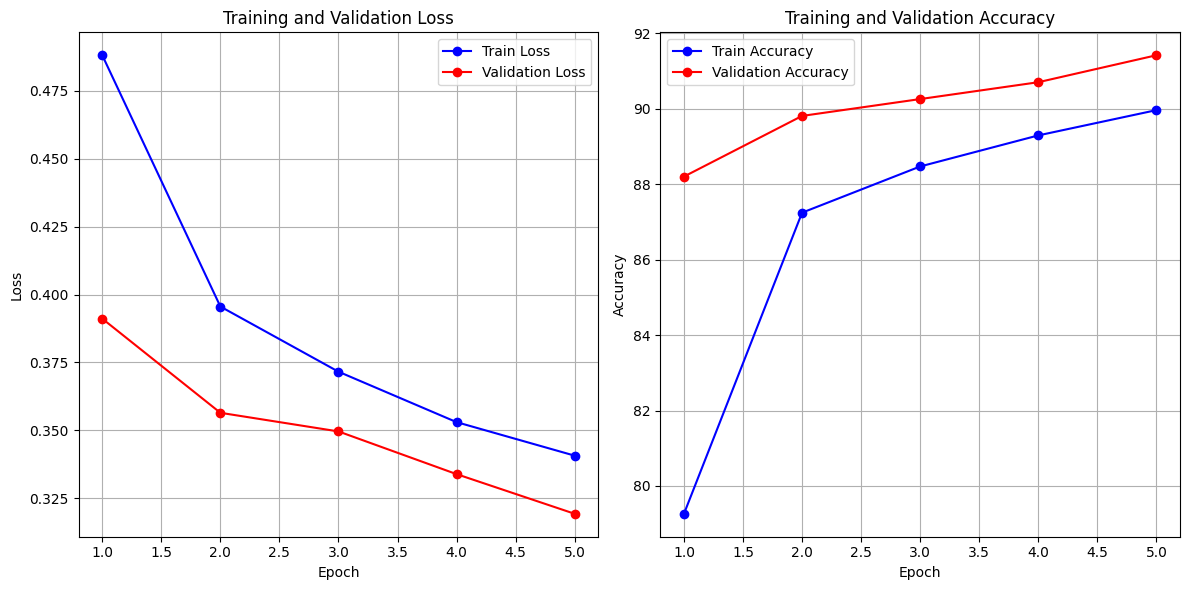

In [150]:
plot_from_history(Fsecondhistory)
# unfreeze - no dense 

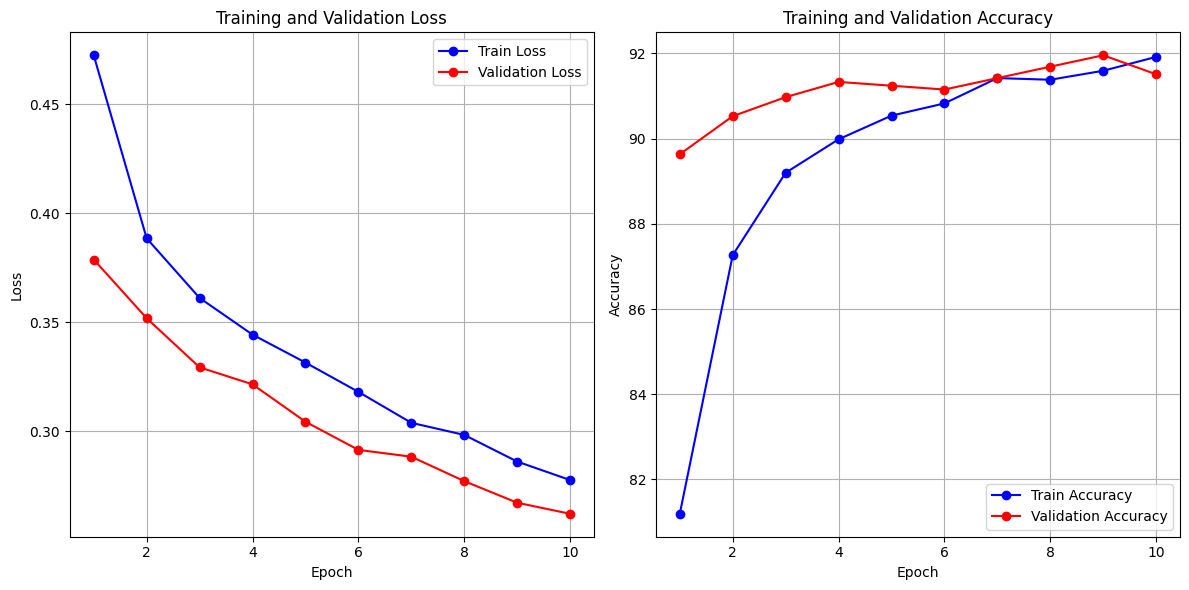

In [157]:
plot_from_history(Fsecondhistory)
# unfreeze

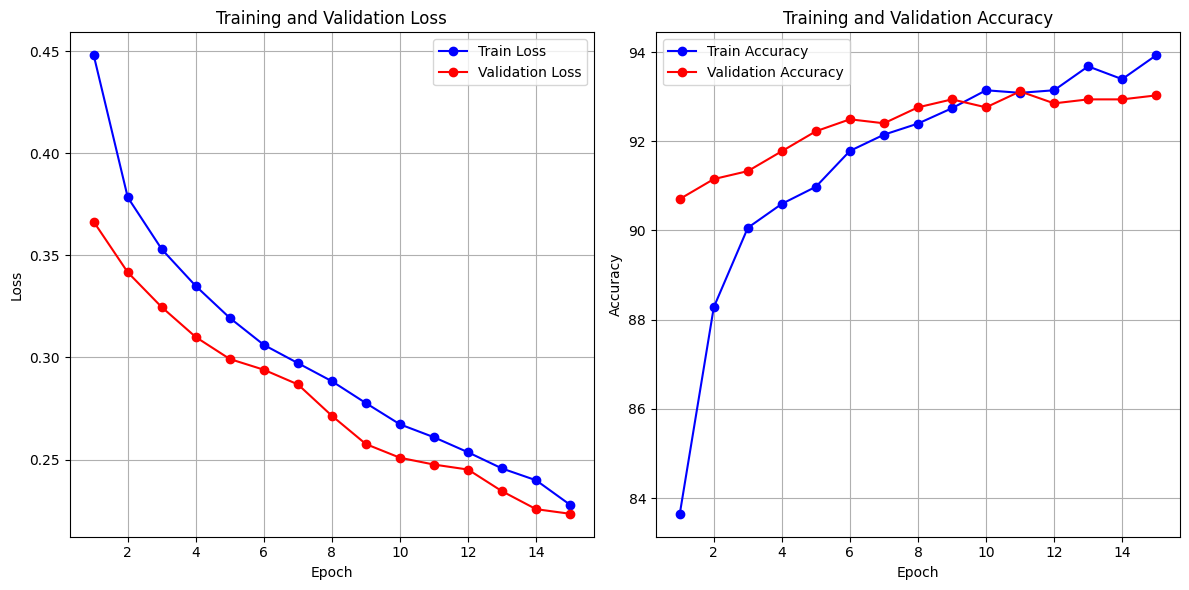

In [163]:
plot_from_history(Fsecondhistory)
# unfreeze

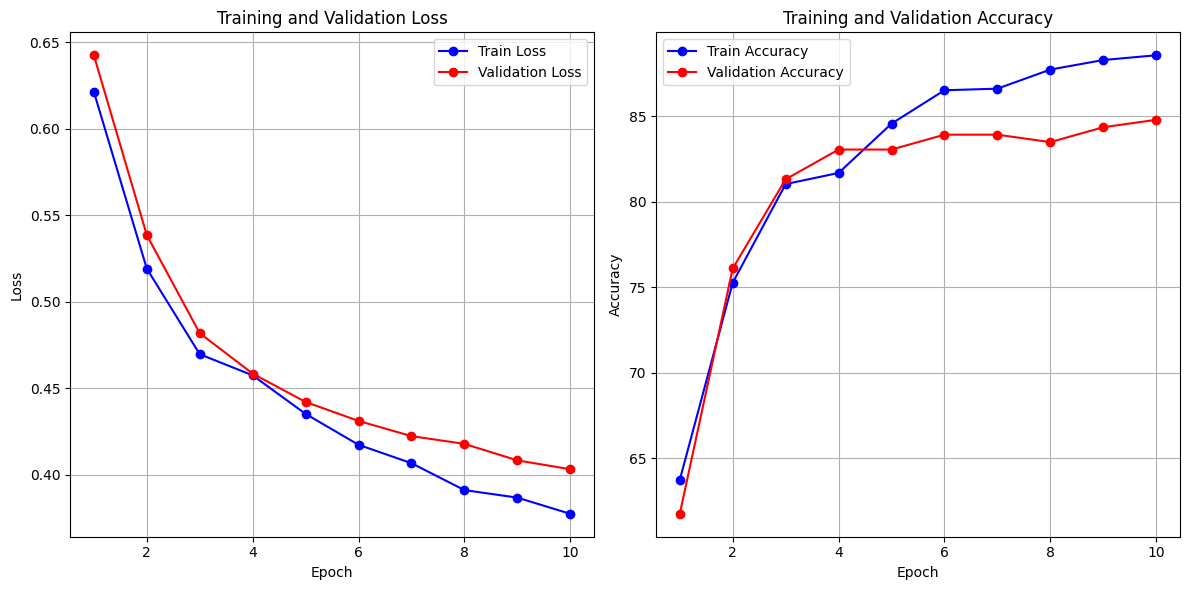

In [40]:
plot_from_history(Fsecondhistory)
# unfreeze

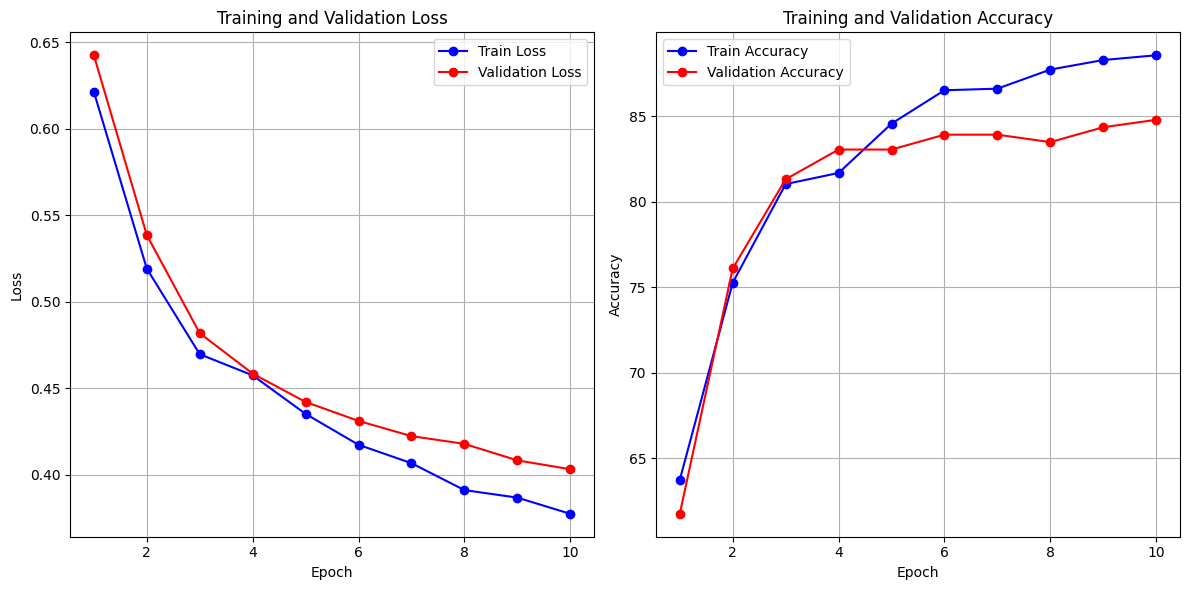

In [46]:
plot_from_history(Fsecondhistory)
# freezed 5 epochs augmented no dense 

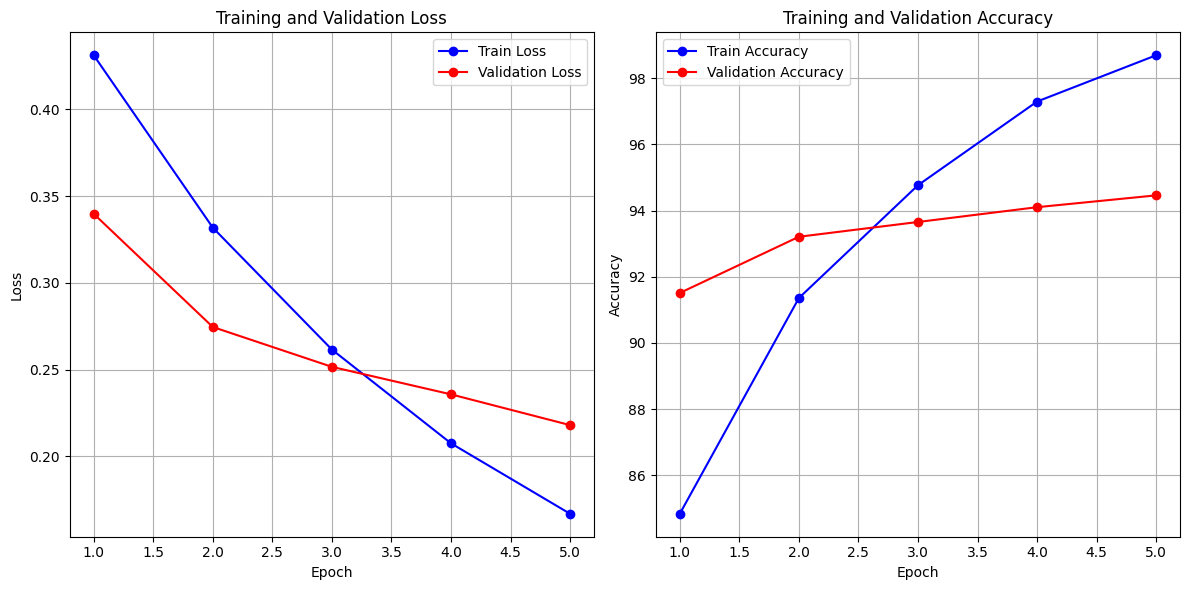

In [139]:
plot_from_history(Fsecondhistory)
# freezed 15 epochs non augmented no dense 

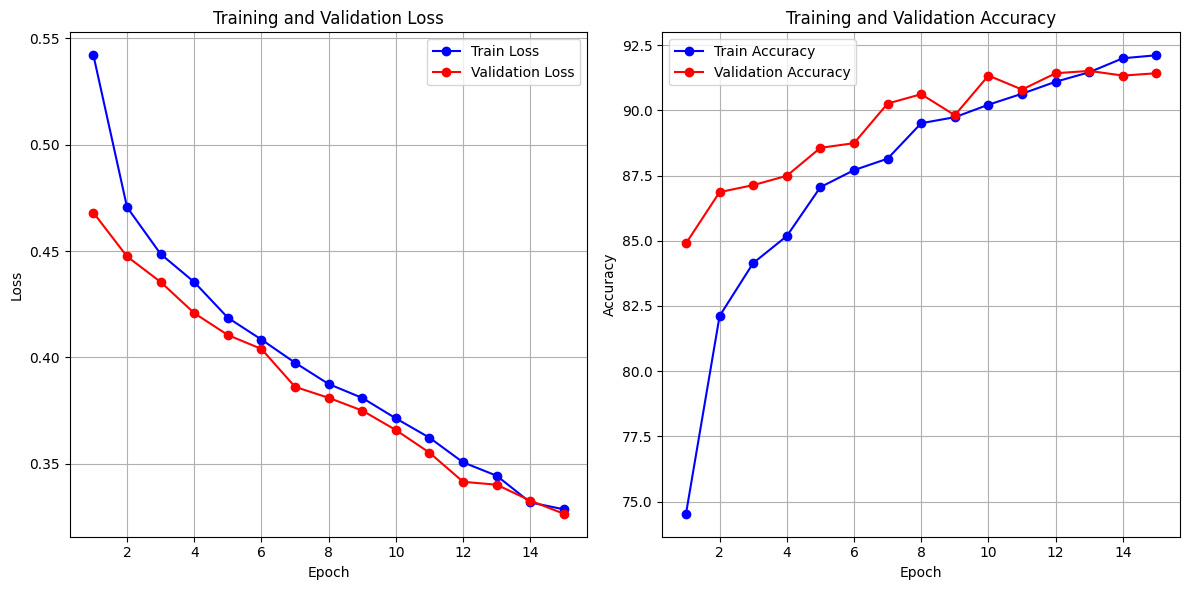

In [17]:
plot_from_history(Fsecondhistory)
# freezed 15 epochs non augmented

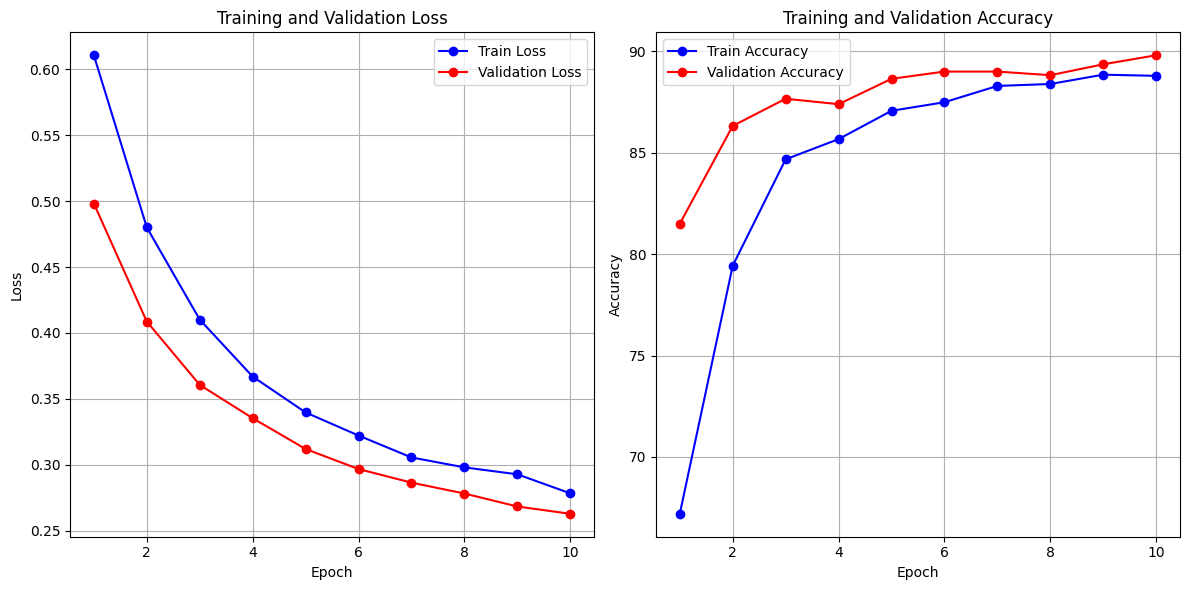

In [24]:
plot_from_history(Fsecondhistory)
# freezed 10 epochs non augmented nodense

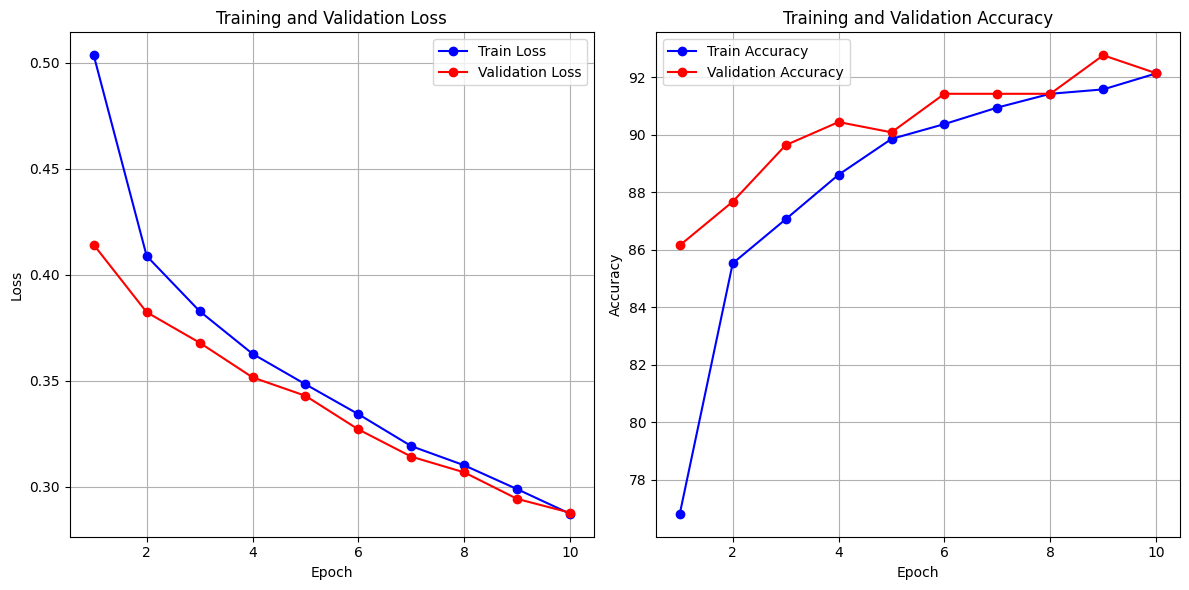

In [19]:
plot_from_history(Fsecondhistory)
# freezed 10 epochs non augmented

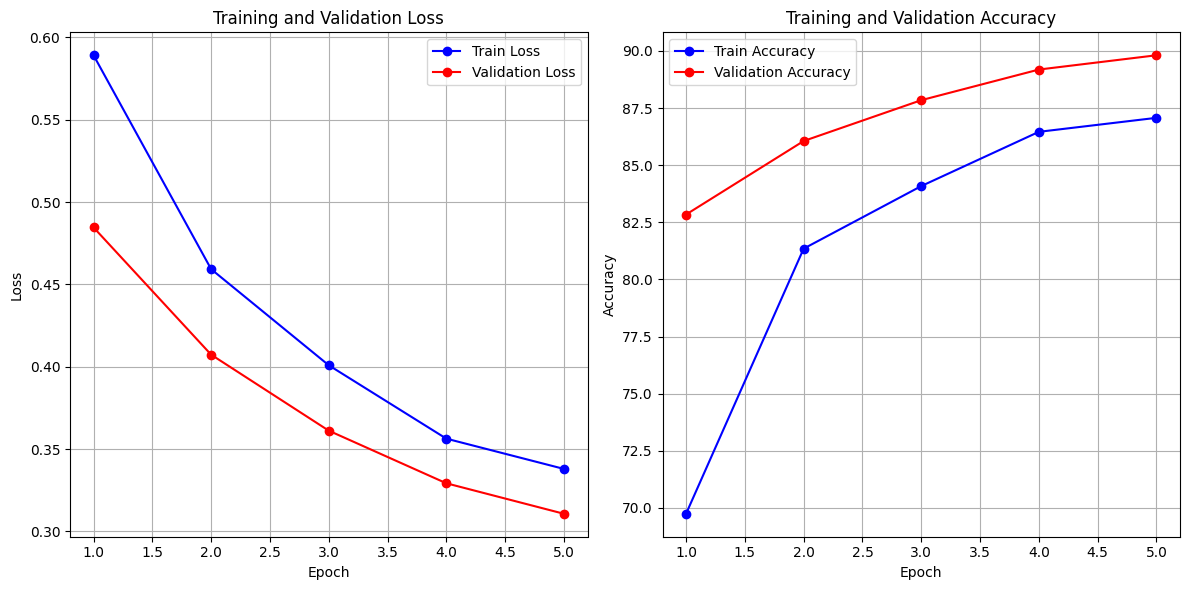

In [38]:
plot_from_history(Fsecondhistory)
# freezed 5 epochs non augmented no dense 

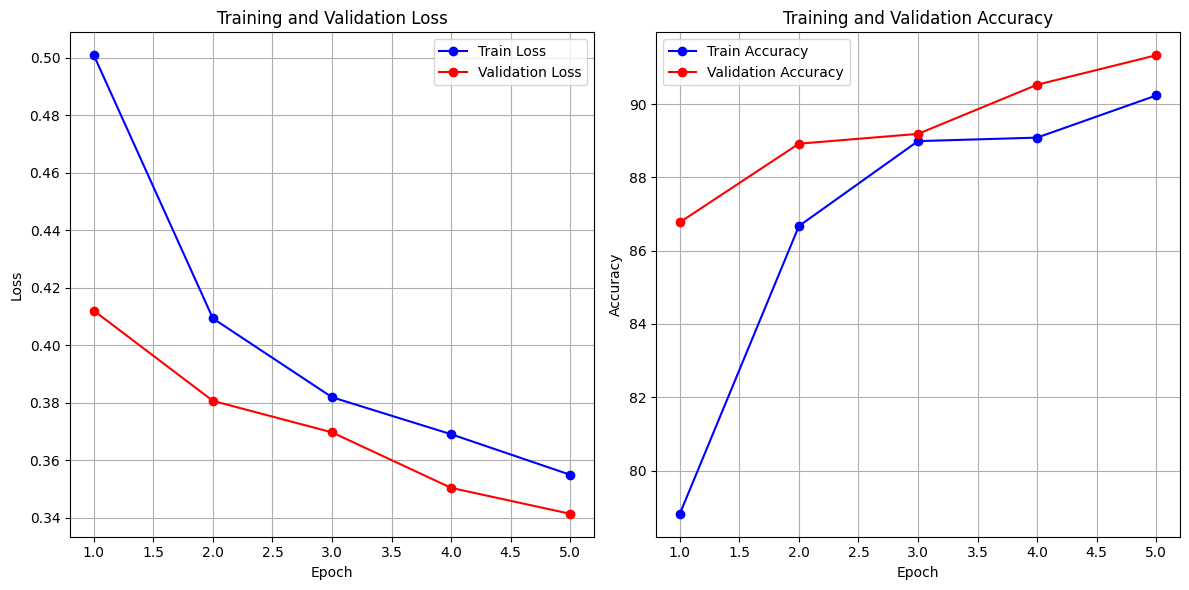

In [11]:
plot_from_history(Fsecondhistory)
# freezed 5 epochs non augmented

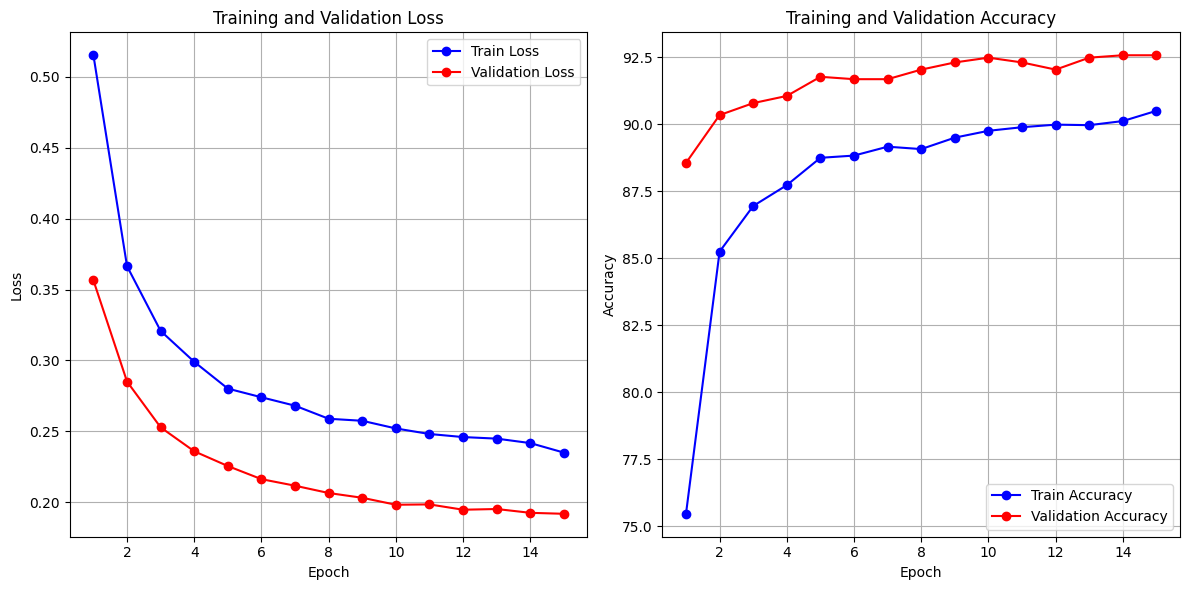

In [ ]:
plot_from_history(Fsecondhistory)
#no dense

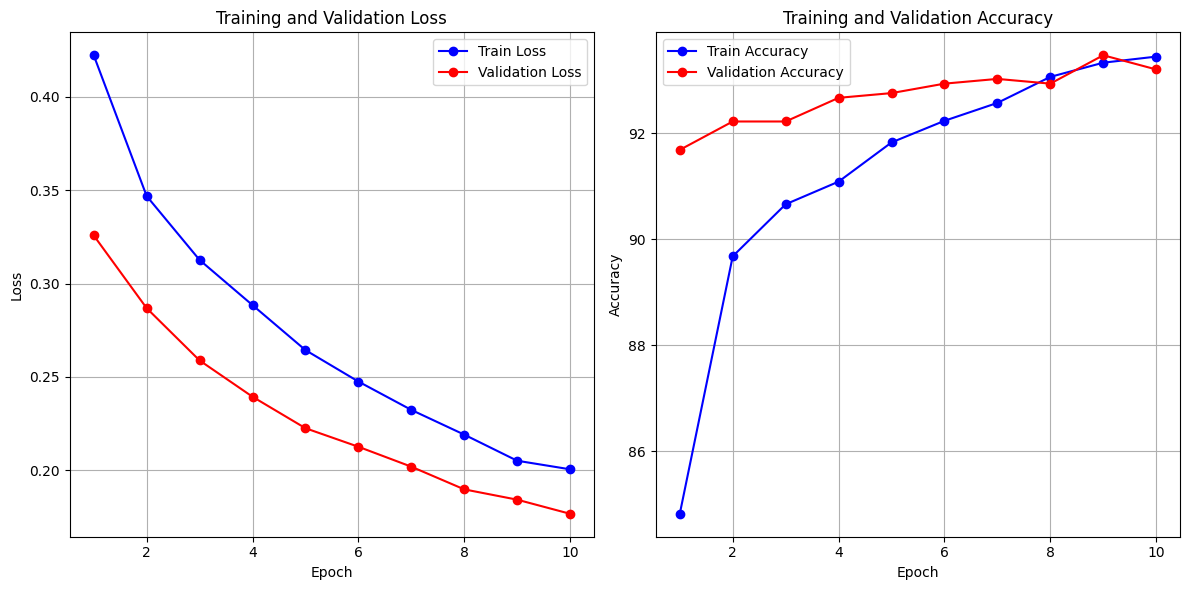

In [43]:
plot_from_history(Fsecondhistory)
# .001 - 64 - 32dense

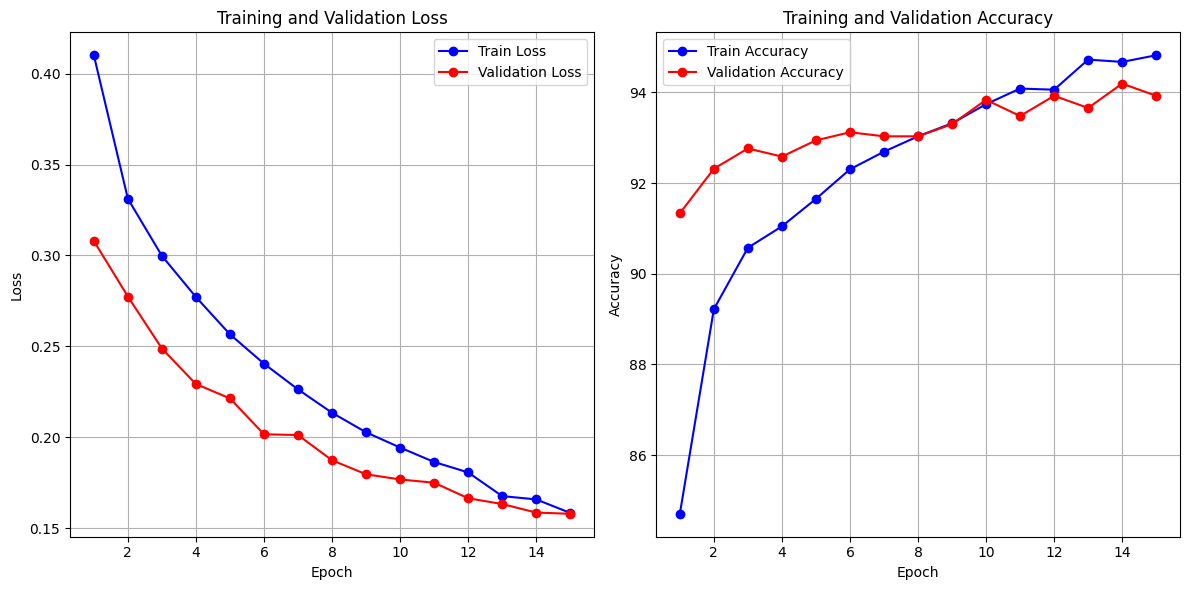

In [7]:
plot_from_history(Fsecondhistory)


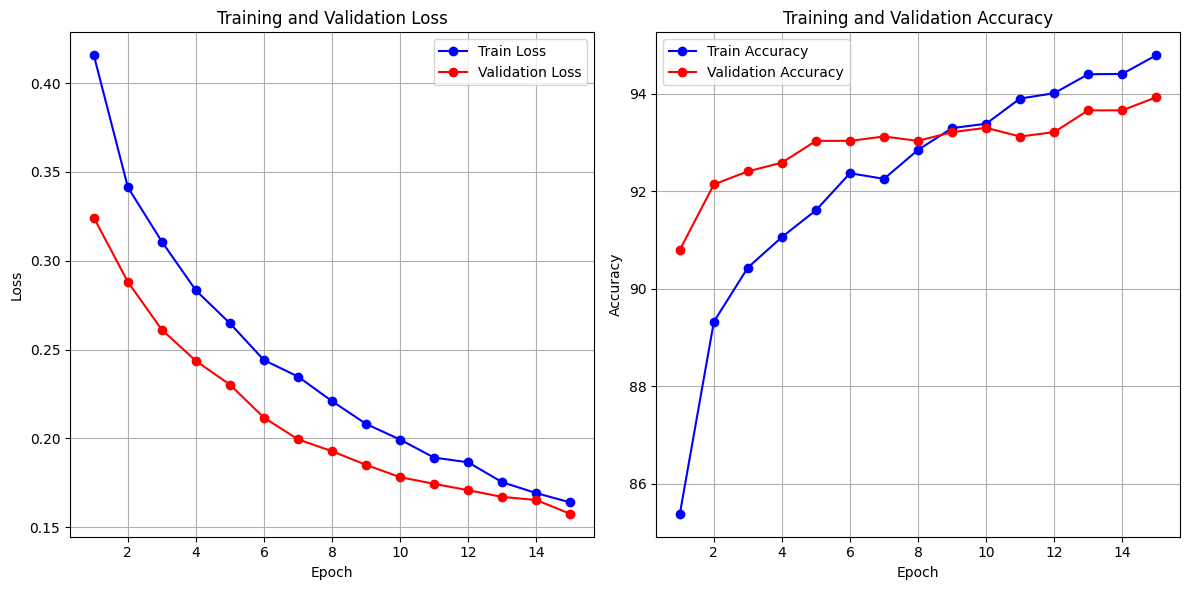

In [ ]:
plot_from_history(Fsecondhistory)
# .001 - 64 - 32dense

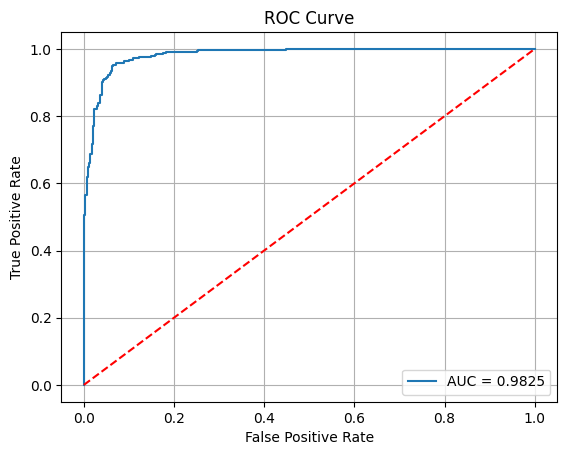

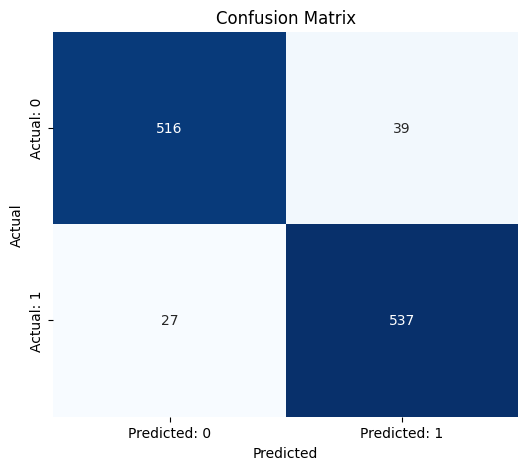

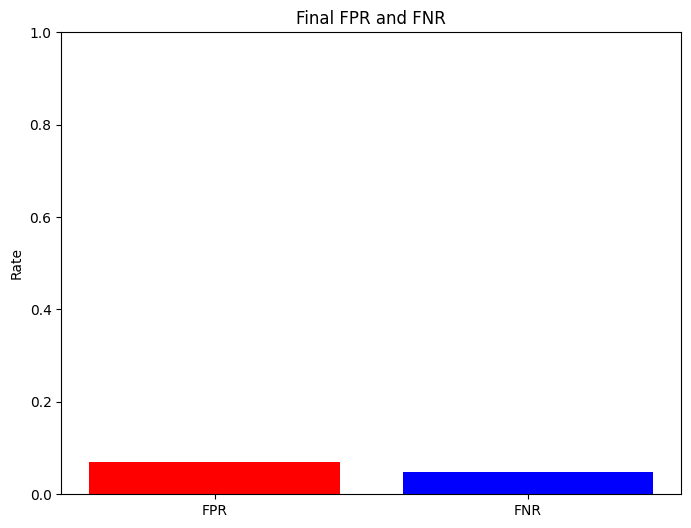

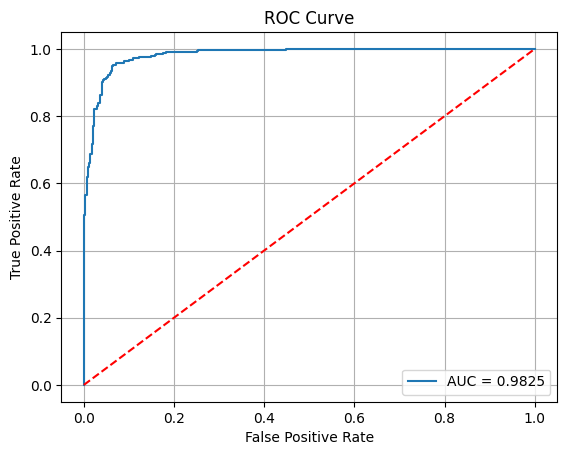

In [28]:
# Fsecondmetrics_flat = {
#     "class_names": Fsecondmetrics["class_names"],
#     "fpr": Fsecondmetrics["fpr"],
#     "fnr": Fsecondmetrics["fnr"],
#     "auc_roc": Fsecondmetrics["auc_roc"],
#     "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in Fsecondmetrics["roc_curve_fpr"]],
#     "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in Fsecondmetrics["roc_curve_tpr"]],
#     "confusion_matrix": [', '.join(map(str, cm)) for cm in Fsecondmetrics["confusion_matrix"]]
# }

Fsecondmetrics_flat = {
    "class_names": test_metrics["class_names"],
    "fpr": test_metrics["fpr"],
    "fnr": test_metrics["fnr"],
    "auc_roc": test_metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in test_metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in test_metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in test_metrics["confusion_matrix"]]
}

plot_roc_curve(Fsecondmetrics_flat)
plot_metrics(Fsecondmetrics_flat)

### Save training results

In [193]:
Fsecondmetrics_flat = {
    "class_names": test_metrics["class_names"],
    "fpr": test_metrics["fpr"],
    "fnr": test_metrics["fnr"],
    "auc_roc": test_metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in test_metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in test_metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in test_metrics["confusion_matrix"]]
}
with open("FINETUNING/Proposed/fixedproposed_classification_report15epochs_finetune4.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracyscore}\n") 

# df = pd.DataFrame(Fsecondhistory)
# df.to_csv('ECD TRAINING/Proposed/fixedsecond_training_history15epochs_noaug.csv', index=False)
# metrics_df = pd.DataFrame(Fsecondmetrics_flat)
# metrics_df.to_csv('ECD TRAINING/Proposed/fixedcecond_training_metrics15epochs_noaug.csv', index=False)



#### Read Saved Results

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       124
           1       0.84      0.90      0.87       107

    accuracy                           0.87       231
   macro avg       0.87      0.88      0.87       231
weighted avg       0.88      0.87      0.87       231

Accuracy Score: 0.8744588744588745



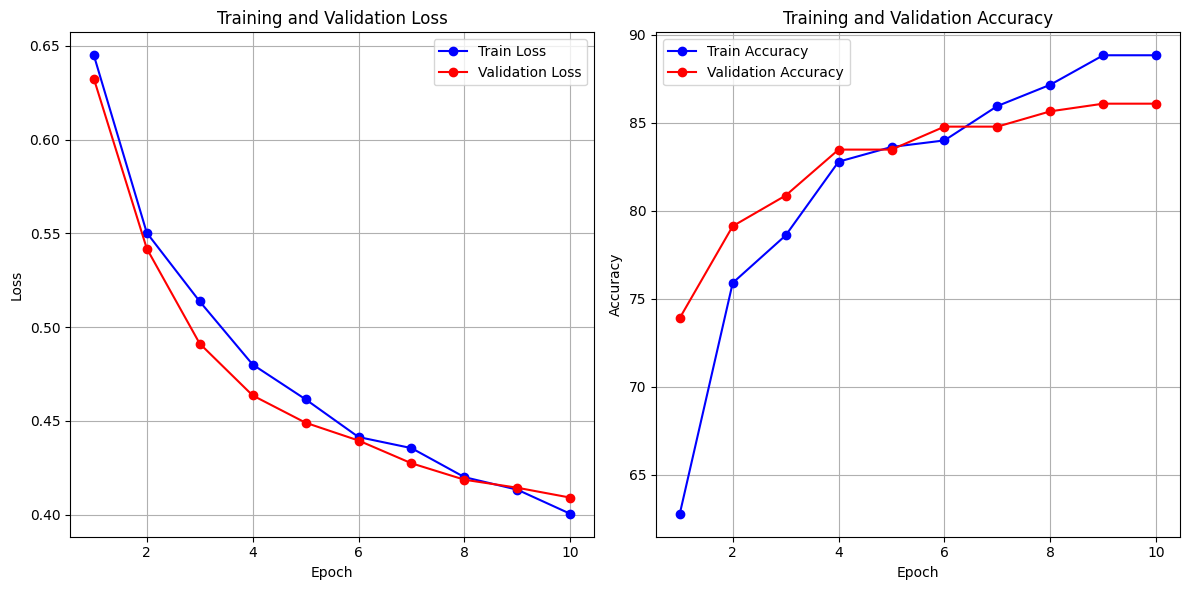

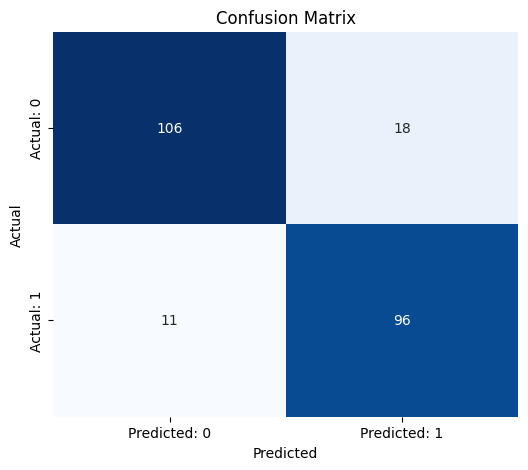

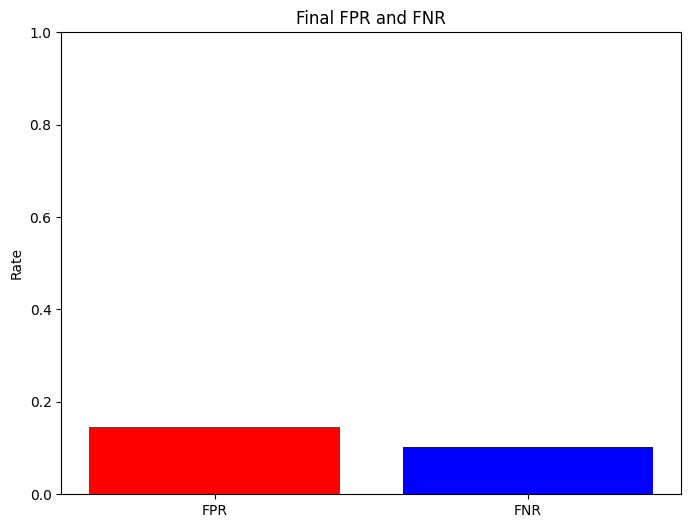

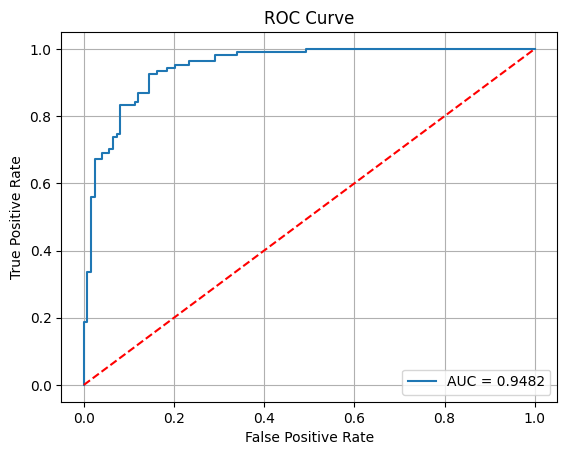

In [60]:
with open("MMU TRAINING/Proposed/fixedproposed_classification_report15epochsMMU_noaug_32.txt", "r") as file:
    reports = file.read()

print(reports)

history_df = pd.read_csv('MMU TRAINING/Proposed/fixedsecond_training_history10epochsMMU_noaug_32.csv')
Fsecondhistorye= {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}
plot_from_history(Fsecondhistorye)

metrics_dfs = pd.read_csv('MMU TRAINING/Proposed/fixedcecond_training_metrics15epochsMMU_noaug_32.csv')
plot_metrics(metrics_dfs)

## Save Models

In [165]:
# torch.save(model, "../Saved models/fixedresnet_inception_fullmodel_cropped10epochs_non-aug_nodense.pth")
scripted_model = torch.jit.script(model)  # Convert model to TorchScript
scripted_model.save("ECD TRAINING/Proposed/Model/fixedresnet_inception_fullmodel_cropped15epochs_no-aug.pt")

#### Use saved model

In [ ]:
from torchvision import transforms
from PIL import Image
import torch

import warnings
class_names = ['Appropriate', 'Inappropriate']

# Suppress specific UserWarning for InceptionV3
warnings.filterwarnings("ignore", message="Scripted Inception3 always returns Inception3 Tuple")

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fussionmodel = torch.load('Saved models/resnet_inception_fullmodel_cropped.pth')
# fussionmodel.to(device)
# fussionmodel.eval() 

fuse = torch.jit.load("../Saved models/resnet_inception_fullmodel_cropped10epochs.pt")
fuse.to(device)
fuse.eval()

# # Perform the forward pass during prediction
# with torch.no_grad():  # Disable gradient tracking during inference for efficiency
#     x_resnet = x_resnet.to(device)  # Make sure the input is on the correct device (CPU/GPU)
#     x_inception = x_inception.to(device)
#     output = model(x_resnet, x_inception)
# # Image preprocessing functions equivalent to TensorFlow preprocessing

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Inception normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_inception = Image.open(img_path).convert('RGB')

    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    img_tensor_inception = inception_transform(img_inception).unsqueeze(0)
    
    return img_tensor_resnet, img_tensor_inception

def predict_image(img_path):
    img_tensor_resnet, img_tensor_inception = preprocess_image(img_path)
    img_tensor_resnet, img_tensor_inception = img_tensor_resnet.to(device), img_tensor_inception.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = fuse(img_tensor_resnet, img_tensor_inception)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    return predicted_class

print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

# BASELINE MODEL 

### Imports

In [ ]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.transforms import InterpolationMode
from PIL import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from torchvision.models import ResNet50_Weights
import os
import numpy as np
from tqdm import tqdm
import glob
import pandas as pd
from torch.utils.data import DataLoader, Dataset,  Subset
from torchvision.datasets import ImageFolder
import seaborn as sns
import random
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from Datapreprocess import AugmentedImageFolder_resnet, Applytransform_resnet
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import torch.optim as optim
from torchinfo import summary
from torch.optim import AdamW  # Import AdamW
save_dir = "./DATASETS/ECD AUGMENTED FULL"



### Data Preprocess and Splitting

In [ ]:

# dataset_path = "./train_45"
dataset_path = "./DATASETS/ECD DATASET CROPPED FULL"
if not os.path.exists(dataset_path):
    print(f"Directory not found: {dataset_path}")
else:
    print(f"Directory found: {dataset_path}")
    print("Contents:", os.listdir(dataset_path))

# Define transformations
transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
val_test_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load raw dataset without transformation
dataset_raw = ImageFolder(dataset_path)
class_names = dataset_raw.classes
class_to_idx = dataset_raw.class_to_idx
print("Class Names:", class_names)

# Extract class indices
labels = [label for _, label in dataset_raw.samples]
appropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Appropriate"]]
inappropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Inappropriate"]]


# Check class sizes
print(f"Appropriate class size: {len(appropriate_indices)}")
print(f"Inappropriate class size: {len(inappropriate_indices)}")

# Plot original class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Original Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# # Balance dataset by undersampling the larger class
# min_class_size = min(len(appropriate_indices), len(inappropriate_indices))
# appropriate_indices = random.sample(appropriate_indices, min_class_size)
# inappropriate_indices = random.sample(inappropriate_indices, min_class_size)

# # Merge & shuffle indices
# balanced_indices = appropriate_indices + inappropriate_indices
# random.shuffle(balanced_indices)

balanced_indices = list(range(len(dataset_raw)))
balanced_indices = shuffle(balanced_indices)


# Define split sizes (70% train, 15% val, 15% test)
train_size = int(0.7 * len(balanced_indices))
val_size = int(0.15 * len(balanced_indices))
test_size = len(balanced_indices) - train_size - val_size

# Split indices
train_indices = balanced_indices[:train_size]
val_indices = balanced_indices[train_size:train_size + val_size]
test_indices = balanced_indices[train_size + val_size:]

# Create Subset datasets
dataset_train = Subset(dataset_raw, train_indices)
dataset_val = Subset(dataset_raw, val_indices)
dataset_test = Subset(dataset_raw, test_indices)

# # Wrap in AugmentedImageFolder for flipping
dataset_train = AugmentedImageFolder_resnet(dataset_train)

# # Apply transformations to val & test sets
# dataset_val = Applytransform_resnet(dataset_val)
# dataset_test = Applytransform_resnet(dataset_test)
# # Create DataLoaders
print(f"Before Augmentation Train set size: {len(dataset_train)}")

dataset_train = datasets.ImageFolder(root=os.path.join(save_dir, "train"), transform=val_test_transform_resnet)
dataset_val = datasets.ImageFolder(root=os.path.join(save_dir, "val"), transform=val_test_transform_resnet)
dataset_test = datasets.ImageFolder(root=os.path.join(save_dir, "test"), transform=val_test_transform_resnet)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Augmented Training Dataset Size: {len(dataset_train)} (Includes Flipped Images)")
print(f"Validation Dataset Size: {len(dataset_val)}")
print(f"Test Dataset Size: {len(dataset_test)}")





### Sample images

In [ ]:
import matplotlib.pyplot as plt
import torch
import random
from PIL import Image
from torchvision import transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display original vs. augmented (flipped) images with mode check
def show_original_vs_augmented(dataset_train, dataset_raw, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        index = random.randint(0, len(dataset_train) // 2 - 1)  # Select from original images only
        original_idx = index * 2  # Original image index
        flipped_idx = original_idx + 1  # Flipped image index

        # Get original file path (before transformation)
        img_path, label_original = dataset_raw.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)
        mode_original = img_pil.mode  # Check mode

        # Load images from dataset_train (already transformed)
        img_original, label_original = dataset_train[original_idx]
        img_flipped, label_flipped = dataset_train[flipped_idx]

        # Convert tensors to numpy for display
        img_original_np = img_original.permute(1, 2, 0).numpy()
        img_flipped_np = img_flipped.permute(1, 2, 0).numpy()

        # Display original
        axes[0, i].imshow(img_original_np)
        axes[0, i].set_title(f"Original ({mode_original}) - {dataset_raw.classes[label_original]}")
        axes[0, i].axis("off")

        # Display flipped
        axes[1, i].imshow(img_flipped_np)
        axes[1, i].set_title(f"Flipped - {dataset_raw.classes[label_flipped]}")
        axes[1, i].axis("off")

    plt.suptitle("Original vs. Flipped Images from Dataset")
    plt.show()
    

# Show images using `dataset_train`
show_original_vs_augmented(dataset_train, dataset_raw)


## Model Initialization

In [ ]:

# class ResNet50Model(nn.Module):
#     def __init__(self):
#         super(ResNet50Model, self).__init__()
        
#         # Load pre-trained ResNet50 model
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
#         # Freeze all layers initially
#         for param in self.resnet.parameters():
#             param.requires_grad = False
        
#         # Replace the fully connected layer
#         self.resnet.fc = nn.Identity()
        
#         # New classification layer
#         self.batch_norm = nn.BatchNorm1d(2048)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(2048, 1)
        
#     def forward(self, x):
#         features = self.resnet(x)
#         features = self.batch_norm(features)
#         features = self.relu(features)
#         features = self.dropout(features)
#         output = torch.sigmoid(self.fc(features))
#         return output
    
    
    
class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        
        # Load pre-trained ResNet50 model
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
   

        # Freeze all layers initially
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        self.resnet.fc = nn.Identity()
        # Replace the fully connected layer with a new classification layer
        self.resnet.fc = nn.Linear(2048, 1)
        
    def forward(self, x):
        output = torch.sigmoid(self.resnet(x))
        return output


base_model_resnet = ResNet50Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model_resnet = base_model_resnet.to(device)



In [ ]:

# for param in base_model_resnet.resnet.layer4.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
for param in model.resnet.layer3.parameters():  # Unfreezing layer4 (last block)
    param.requires_grad = True



### model summary

In [ ]:
torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(base_model_resnet)
summary(base_model_resnet, input_size=(1, 3, 224, 224))

# for name, param in base_model_resnet.named_parameters():
#     print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

## Plots

In [ ]:
def plot_from_history(history):
    # Extract data from history
    epochs = history["epoch"]
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    train_accuracies = history["train_accuracy"]
    val_accuracies = history["val_accuracy"]

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.savefig('training_history.png')  # PNG image
    plt.show()
  
def plot_roc_curve(metrics):
    auc_score = metrics['auc_roc'][0]
  
    roc_fpr = list(map(float, metrics['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics['roc_curve_tpr'][0].split(', ')))
    # Plot ROC Curve
    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()
def plot_metrics(metrics_df):
    # Extract individual metrics
    auc_score = metrics_df['auc_roc'][0]
    fpr = metrics_df['fpr'][0]
    fnr = metrics_df['fnr'][0]

    # Extract confusion matrix (flattened form)
    conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
    tn, fp, fn, tp = conf_matrix

    # Extract ROC curve data (flattened form)
    roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
    # Confusion Matrix heatmap
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot FPR and FNR
    plt.figure(figsize=(8, 6))
    plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
    plt.ylabel('Rate')
    plt.title('Final FPR and FNR')
    plt.ylim(0, 1)
    plt.show()

    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


## TRAIN LOOP

In [ ]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Training loop
def train_model_baseline(model, train_loader, val_loader, criterion, optimizer, epochs=5, scheduler=None, device="cuda"):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        model.train()
        for batch in progress_bar:
            x_resnet, y = batch
            x_resnet, y = x_resnet.to(device), y.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_resnet).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (preds == y).sum().item()
            total += y.size(0)

            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                x_resnet, y = batch
                x_resnet, y = x_resnet.to(device), y.to(device).float()

                outputs = model(x_resnet).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

        # Store metrics
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Compute Additional Metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_prob)
        fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
        tn, fp, fn, tp = conf_matrix.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        print("\nAdditional Metrics:") 
        print(f"False Positive Rate (FPR): {fpr:.4f}")
        print(f"False Negative Rate (FNR): {fnr:.4f}")
        print(f"AUC-ROC Score: {auc_score:.4f}")
        print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

        # Save Additional Metrics
        metrics["class_names"].append(["Appropriate", "Inappropriate"])
        metrics["confusion_matrix"].append(conf_matrix.ravel())
        metrics["fpr"].append(fpr)
        metrics["fnr"].append(fnr)
        metrics["auc_roc"].append(auc_score)
        metrics["roc_curve_fpr"].append(fpr_vals)
        metrics["roc_curve_tpr"].append(tpr_vals)

        model.train()  # Return model to training mode
        if scheduler:
            print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
            scheduler.step()
            print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

    print("Training complete")
    return history, metrics


### Train Model

In [ ]:

# "STEADY LEARNING RATE"

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, base_model_resnet.parameters()), lr=0.0001, weight_decay=0.0001)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=4)
history, metrics = train_model_baseline(base_model_resnet, train_loader, val_loader,criterion, optimizer, epochs=5, device=device )


### Model Eval Using Test Set

In [ ]:
# base_model_resnet.eval()
# y_true, y_pred, y_prob = [], [], []
    
# with torch.no_grad():
#     for x, y in test_loader:
#         x, y = x.to(device), y.to(device).float()
#         outputs = base_model_resnet(x).squeeze()
#         preds = (outputs > 0.5).cpu().int().numpy()

#         # Store ground-truth labels and predictions
#         y_true.extend(y.cpu().int().numpy())
#         y_pred.extend(preds)
#         y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC
    
#     # Compute Additional Metrics for Test Set
# conf_matrix = confusion_matrix(y_true, y_pred)
# auc_score = roc_auc_score(y_true, y_prob)
# fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
# tn, fp, fn, tp = conf_matrix.ravel()
# fpr = fp / (fp + tn)
# fnr = fn / (fn + tp)
    
#  # Print Test Metrics
# print("\nTest Set Metrics:")
# print(f"False Positive Rate (FPR): {fpr:.4f}")
# print(f"False Negative Rate (FNR): {fnr:.4f}")
# print(f"AUC-ROC Score: {auc_score:.4f}")
# print(f"Confusion Matrix:\n{conf_matrix}")
# print("**Fine-Tuned Model Evaluation**")
    
# report = classification_report(y_true, y_pred)
# print(report)
# print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")
    
def evaluate_resnet_model():
    test_metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    base_model_resnet.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device).float()
            outputs = base_model_resnet(x).squeeze()
            preds = (outputs > 0.5).cpu().int().numpy()

            # Store ground-truth labels and predictions
            y_true.extend(y.cpu().int().numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC

    # Compute Additional Metrics for Test Set
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    # Print Test Metrics
    print("\nTest Set Metrics:")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("**Fine-Tuned Model Evaluation**")

    # Store metrics in dictionary
    test_metrics["class_names"].append(["Appropriate", "Inappropriate"]) 
    test_metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    test_metrics["fpr"].append(fpr)
    test_metrics["fnr"].append(fnr)
    test_metrics["auc_roc"].append(auc_score)
    test_metrics["roc_curve_fpr"].append(fpr_vals)
    test_metrics["roc_curve_tpr"].append(tpr_vals)

    # Classification Report & Accuracy
    report = classification_report(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    print(report)
    print(f"Accuracy Score: {accuracy}")

    return test_metrics, report, accuracy


test_metrics, report, accuracy = evaluate_resnet_model()

### Training results


In [ ]:
plot_from_history(history)

In [ ]:
metrics_flat = {
    "class_names": test_metrics["class_names"],
    "fpr": test_metrics["fpr"],
    "fnr": test_metrics["fnr"],
    "auc_roc": test_metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in test_metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in test_metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in test_metrics["confusion_matrix"]]
}

# plot_roc_curve(metrics_flat)
plot_metrics(metrics_flat)

### Save training results

In [ ]:

with open("training_history/Baseline_classification_reportv11.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracy}\n") 

df = pd.DataFrame(history)
df.to_csv('training_history/Baseline_training_historyv7.csv', index=False)
metrics_df = pd.DataFrame(metrics_flat)
metrics_df.to_csv('training_history/Baseline_training_metricsv7.csv', index=False)



#### Read Train Results

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.92      0.96        12

    accuracy                           0.93        15
   macro avg       0.88      0.96      0.91        15
weighted avg       0.95      0.93      0.94        15

Accuracy Score: 0.9333333333333333



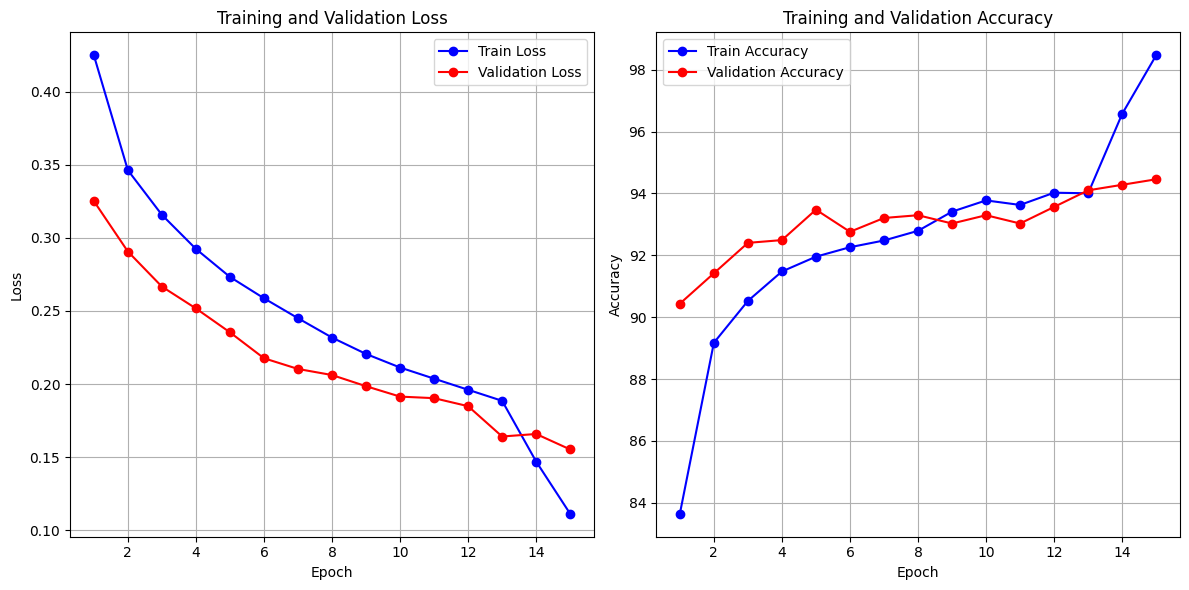

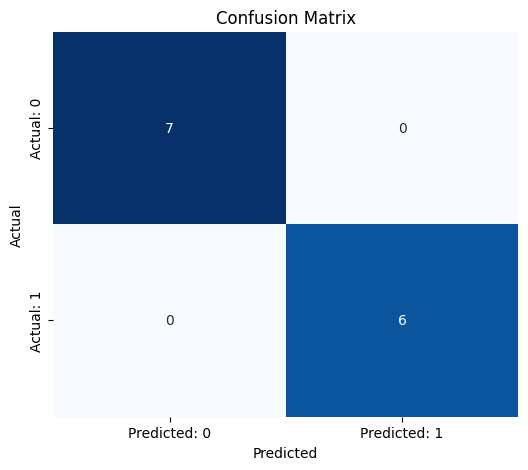

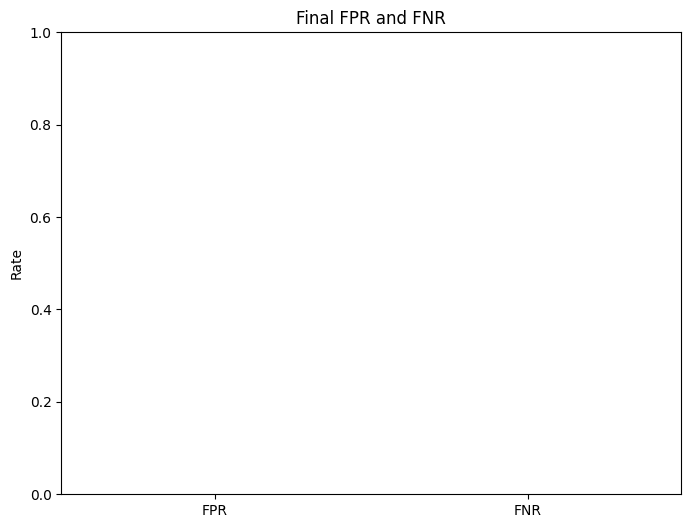

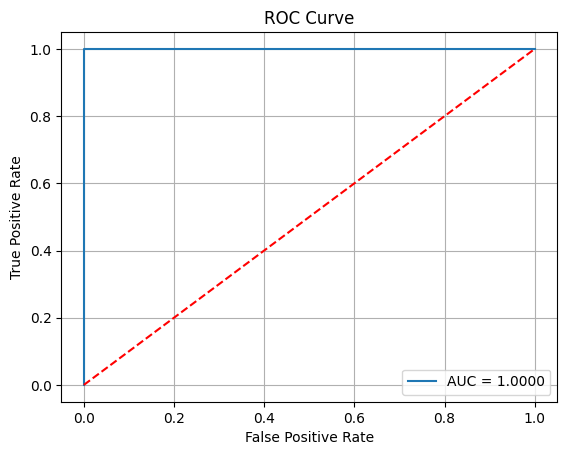

In [191]:
with open("training_history/Baseline_classification_reportv11.txt", "r") as file:
    report = file.read()

print(report)

history_df = pd.read_csv('training_history/fixedsecond_training_history15epochs_finetune4.csv')
history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}
plot_from_history(history)
metrics_df = pd.read_csv('training_history/Baseline_training_metricsv7.csv')

plot_metrics(metrics_df)

##  Save Models


In [ ]:
torch.save(base_model_resnet, "../Saved models/Baseline_resnet_fullmodel_croppedv7.pth")
scripted_model = torch.jit.script(base_model_resnet)  # Convert model to TorchScript
scripted_model.save("../Saved models/Baseline_resnet_fullmodel_croppedv7.pt")

### Use saved Model

In [ ]:
from torchvision import transforms
from PIL import Image
import torch

import warnings
class_names = ['Appropriate', 'Inappropriate']

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


base_model = torch.jit.load("../Saved models/Baseline_resnet_fullmodel_croppedv7.pt")
base_model.to(device)
base_model.eval()

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])


def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    
    return img_tensor_resnet

def predict_image(img_path):
    img_tensor_resnet = preprocess_image(img_path)
    img_tensor_resnet = img_tensor_resnet.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = base_model(img_tensor_resnet)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    return predicted_class

print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")